# Clustering

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.ga import genetic_algorithm, ga_observer, ga_visualizer

In [2]:
# Starting dataset
df = pd.read_csv('datasets/customer_dataframe.csv', sep='\t', index_col=0)
df

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth
CustomerID,,,,,,,,,,,,,
17850,1702,21,48.629,5317.89,6.36,107.25,151.940,31,3.960,34,4.137,3.186,Feb
13047,1355,105,84.688,3089.10,6.64,68.00,193.069,35,3.926,9,5.421,3.875,Jan
12583,4978,114,292.824,6629.34,6.80,132.80,389.961,50,2.140,15,5.804,4.087,Aug
13748,439,24,87.800,948.25,9.36,204.00,189.650,0,3.996,5,4.080,2.322,May
15100,58,1,9.667,635.10,175.20,350.40,105.850,22,10.950,3,2.252,2.252,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13436,76,12,76.000,196.89,10.20,25.50,196.890,0,5.830,1,3.418,0.000,Aug
15520,314,18,314.000,343.50,9.48,34.68,343.500,0,1.724,1,2.997,0.000,Aug
13298,96,2,96.000,360.00,90.00,270.00,360.000,0,3.750,1,1.000,0.000,Aug


For the clustering process we decided to work only on a small part of the indexes, choosing only the ones that better represent the customer behaviour. <br>
We decided to exploit means attributes since they are more robust.

In [3]:
selected_features = ['TProd','MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']
df_aux = df[selected_features]
df_aux.head()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
CustomerID,,,,
17850,1702,48.629,151.940,3.960
13047,1355,84.688,193.069,3.926
12583,4978,292.824,389.961,2.140
13748,439,87.800,189.650,3.996
15100,58,9.667,105.850,10.950


In [4]:
df_aux.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,-0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


# Normalization

Normalization of data to avoid the dominance - bias- of attributes with higher magnitude than others.

In [4]:
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df_aux.to_numpy())

In [6]:
ndf = pd.DataFrame(df_norm, columns=df_aux.columns)
ndf

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
0,0.008659,0.006215,0.015340,0.008833
1,0.006894,0.010824,0.019492,0.008754
2,0.025326,0.037426,0.039371,0.004644
3,0.002233,0.011222,0.019147,0.008915
4,0.000295,0.001236,0.010687,0.024919
...,...,...,...,...
4328,0.000387,0.009714,0.019878,0.013136
4329,0.001598,0.040133,0.034680,0.003687
4330,0.000488,0.012270,0.036346,0.008349
4331,0.000402,0.010097,0.022957,0.008741


<AxesSubplot:>

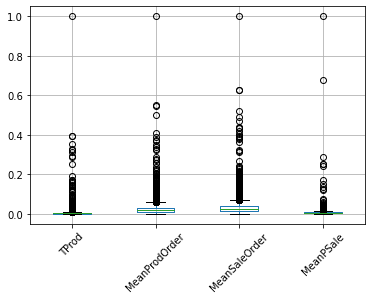

In [7]:
ndf.boxplot(list(ndf.columns), rot=45)

***

# K-MEANS

Run K-Means for values of K in range 2-14 in order to find the best value.<br>
The analysis will be based on 3 different indicators: SSE, Silhouette and Davies-Bouldin.

In [8]:
sse_list = list()
sil_list = list()
davies_list = list()
max_k = 15
for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over possible K values"):
    kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans_iter.fit(df_norm)
    
    davies_list.append(davies_bouldin_score(df_norm, kmeans_iter.labels_))
    sil_list.append(silhouette_score(df_norm, kmeans_iter.labels_))
    sse = kmeans_iter.inertia_
    sse_list.append(sse)

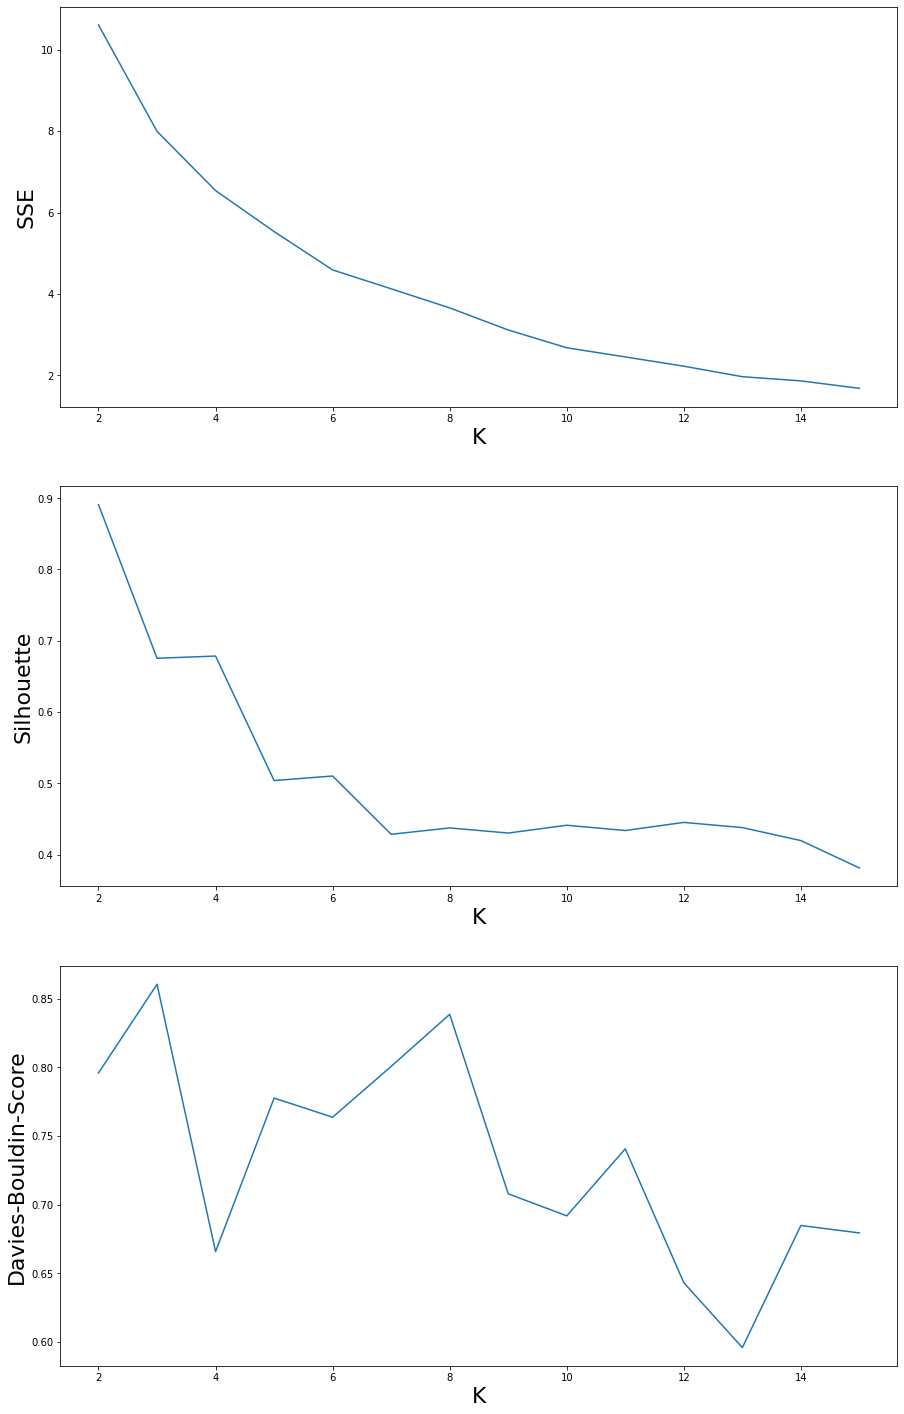

In [9]:
# plot indicators
fig, axs = plt.subplots(3,1,figsize=(15,25))
axs[0].plot(range(2, len(sse_list) + 2), sse_list)
axs[0].set_ylabel('SSE', fontsize=22)
axs[0].set_xlabel('K', fontsize=22)
axs[0].tick_params(axis='both', which='major', labelsize=10)

axs[1].plot(range(2, len(sil_list) + 2), sil_list)
axs[1].set_ylabel('Silhouette', fontsize=22)
axs[1].set_xlabel('K', fontsize=22)
axs[1].tick_params(axis='both', which='major', labelsize=10)

axs[2].plot(range(2, len(davies_list) + 2), davies_list)
axs[2].set_ylabel('Davies-Bouldin-Score', fontsize=22)
axs[2].set_xlabel('K', fontsize=22)
axs[2].tick_params(axis='both', which='major', labelsize=10)

With the elbow rule and looking at the graphs we see that the best value of K is 4

In [10]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(df_norm)
print("SSE:",sse_list[k-2]," - SILHOUETTE:",sil_list[k-2])

SSE: 6.538689611545758  - SILHOUETTE: 0.6785957622596577


In [11]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

#saving anomalous cluster index
anomalous_cluster = -1
for key, value in dict(zip(bins, hist)).items():
    if value == 1:
        anomalous_cluster = key

{0: 3857, 1: 25, 2: 450, 3: 1}


We can already start seeing an anomalous cluster, composed only by 1 value, let us analyze more the situation

Text(0.5, 0, 'MeanSaleOrder')

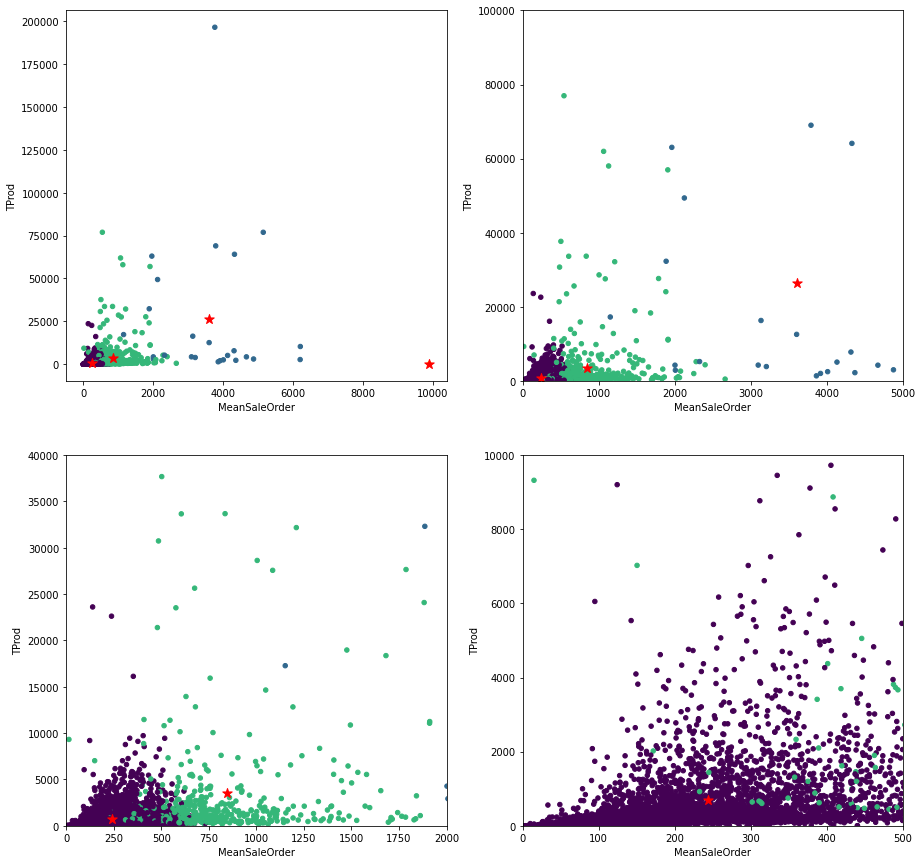

In [12]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
fig, axs = plt.subplots(2,2,figsize=(15,15))
label_s = 10
col1, i1 = df_aux['MeanSaleOrder'], 2
col2, i2 = df_aux['TProd'], 0

axs[0][0].scatter(col1, col2, c=kmeans.labels_, s=20)
axs[0][0].scatter(centers[:, i1], centers[:, i2], s=100, marker='*', c='r')
axs[0][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[0][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[0][1].set_xlim((0,5000))
axs[0][1].set_ylim((0,100000))
axs[0][1].scatter(col1, col2, c=kmeans.labels_, s=20)
axs[0][1].scatter(centers[:, i1], centers[:, i2], s=100, marker='*', c='r')
axs[0][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[0][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[1][0].set_xlim((0,2000))
axs[1][0].set_ylim((0,40000))
axs[1][0].scatter(col1, col2, c=kmeans.labels_, s=20)
axs[1][0].scatter(centers[:, i1], centers[:, i2], s=100, marker='*', c='r')
axs[1][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[1][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[1][1].set_xlim((0,500))
axs[1][1].set_ylim((0,10000))
axs[1][1].scatter(col1, col2, c=kmeans.labels_, s=20)
axs[1][1].scatter(centers[:, i1], centers[:, i2], s=100, marker='*', c='r')
axs[1][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[1][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

We can see how the anomalous cluster is well separated and completely on its own

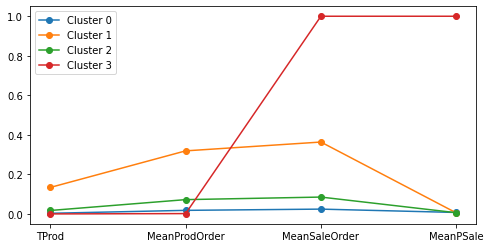

In [13]:
# normalized centers
plt.figure(figsize=(8, 4))
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

We can further appreciate how the anomalous cluster has a completely different approach from the others (which follow more a parabolic like shape)

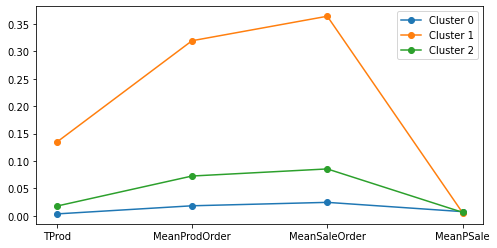

In [14]:
# normalized centers without anomalous cluster
plt.figure(figsize=(8, 4))
for i in range(0, len(kmeans.cluster_centers_)):
    if i != anomalous_cluster:
        plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

In [15]:
# create column containing cluster label
df['Cluster'] = kmeans.labels_
# create structure containing each single cluster
clust_list = list()
for i in tqdm(range(len(df['Cluster'].unique())), total=len(df['Cluster'].unique()), desc="Creating cluster dataframes"):
    clust_list.append(df[df['Cluster'] == i])

{0: 3857, 1: 25, 2: 450, 3: 1}


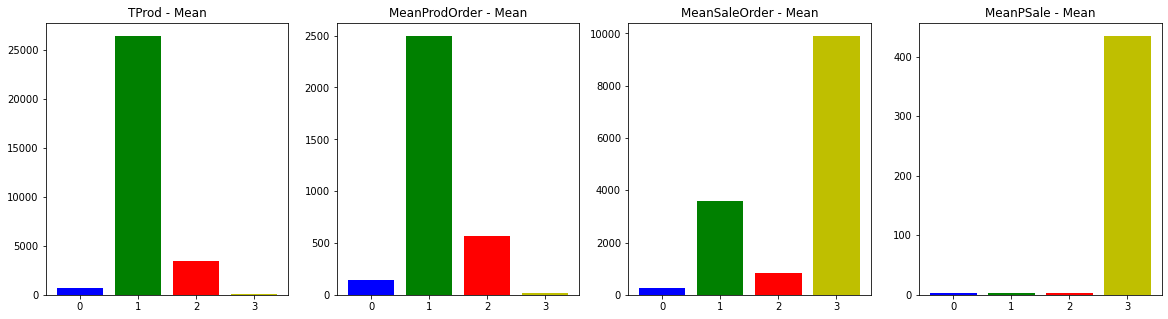

In [16]:
# plot attributes descriptions
attr = df_aux.columns
clusters = range(len(clust_list))
fig, axs = plt.subplots(1,len(attr),figsize=(20,5))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for cluster_df in clust_list:
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index].bar(clusters, mean_values, color = ['b','g','r','y'])
    axs[attr_index].set_title(f"{attr[attr_index]} - Mean")
print(clust_dict)

Since the anomalous cluster is composed by only 1 value it has also anomalous mean values, ruining the analysis

## POST PROCESSING

In [17]:
# taking a peak at this weird cluster
clust_list[anomalous_cluster]

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth,Cluster
CustomerID,,,,,,,,,,,,,,
15098,61,1,15.25,39619.5,297.0,38970.0,9904.875,60,434.65,3,2.0,2.0,Oct,3


What happens if we try to merge the anomalous cluster with the one most similar to it? 

In [18]:
# saving index for most similar cluster (the cluster with 25 elements as we can see in the plots above)
to_englobe = -1
for key in clust_dict.keys():
    if clust_dict[key] == 25:
        to_englobe = key
# visualize description of most similar cluster
clust_list[to_englobe].describe()['MeanPSale']

count    25.00000
mean      2.60540
std       1.50657
min       0.40000
25%       1.04800
50%       2.54400
75%       3.34900
max       5.73100
Name: MeanPSale, dtype: float64

In [19]:
# merging two clusters together
clust_list_merge = clust_list[to_englobe].copy()
clust_list_merge = clust_list_merge.append(clust_list[anomalous_cluster])

In [20]:
# visualize description of most similar cluster + anomalous customer
clust_list_merge.describe()['MeanPSale']

count     26.000000
mean      19.222500
std       84.743774
min        0.400000
25%        1.234000
50%        2.647000
75%        3.553000
max      434.650000
Name: MeanPSale, dtype: float64

We can see how adding this single value alters greatly various descriptive values and this alters the cluster meaning in a non superficial way

**Decision taken:** drop the anomalous cluster, we can see it as noise bringing no information to the analysis

In [21]:
clust_dict.pop(anomalous_cluster, None)
clust_list.pop(anomalous_cluster)

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth,Cluster
CustomerID,,,,,,,,,,,,,,
15098,61,1,15.25,39619.5,297.0,38970.0,9904.875,60,434.65,3,2.0,2.0,Oct,3


{0: 3857, 1: 25, 2: 450}


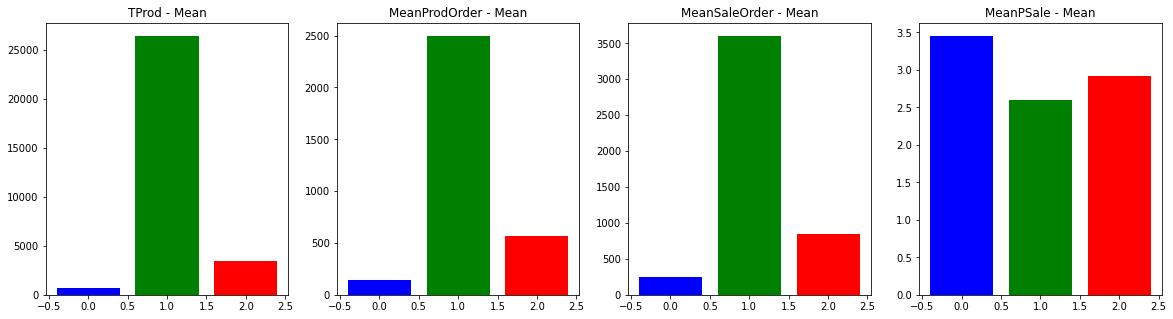

In [22]:
# Re-Plot the statistics of the clusters
attr = df_aux.columns
clusters = range(len(clust_list))
fig, axs = plt.subplots(1,len(attr),figsize=(20,5))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for cluster_df in clust_list:
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index].bar(clusters, mean_values, color = ['b','g','r','y'])
    axs[attr_index].set_title(f"{attr[attr_index]} - Mean")
print(clust_dict)

## ANALYSIS

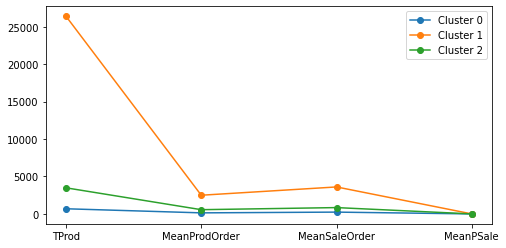

In [23]:
# non normalized centers
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    if i != anomalous_cluster:
        plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

In [24]:
# TODO: add analysis of clusters

In [25]:
# memory cleaning to avoid saturation
del sse_list, sil_list, davies_list, max_k, fig, axs, k, kmeans, hist, bins, clust_dict, anomalous_cluster
del centers, label_s, col1, i1, col2, i2, attr, clusters, clust_list, to_englobe, clust_list_merge

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR9IawGaGT3e7eXNCxCk4UbFMXvygnOwOrnQg&usqp=CAU"/>

# Density-based clustering

We decided to work on the same subset of attributes chosen for K-Means

In [ ]:
df_aux.head()

## DBSCAN

In [27]:
dist = pdist(X=df_norm, metric='euclidean')  # pair-wise distance: how every record is far from all others
dist = squareform(dist)                      # distance matrix given the vector dist

Calculate the distance of the K-th neighbour, in order to find the best value of K

In [28]:
kmin, kmax = 3, 30
kth_distances = {k:[] for k in range(kmin, kmax + 1)} # initialize k lists

for d in dist:
    # argsort returns the indexes that would sort d
    indexes_to_sort_d = np.argsort(d)
    for k in range(kmin, kmax + 1):
        # append to kth_distances[k] the value in d that corresponds
        # to the distance of the i-th point (record) from its k-th nn.
        # it's like: kth_distances[k].append(sorted_d[k])), but we get "sorted_d[k]" by d[indexes_to_sort_d[k]]
        kth_distances[k].append(d[indexes_to_sort_d[k]])

Plot, for every value of K in *[3800, Kmax]*, the sorted distances

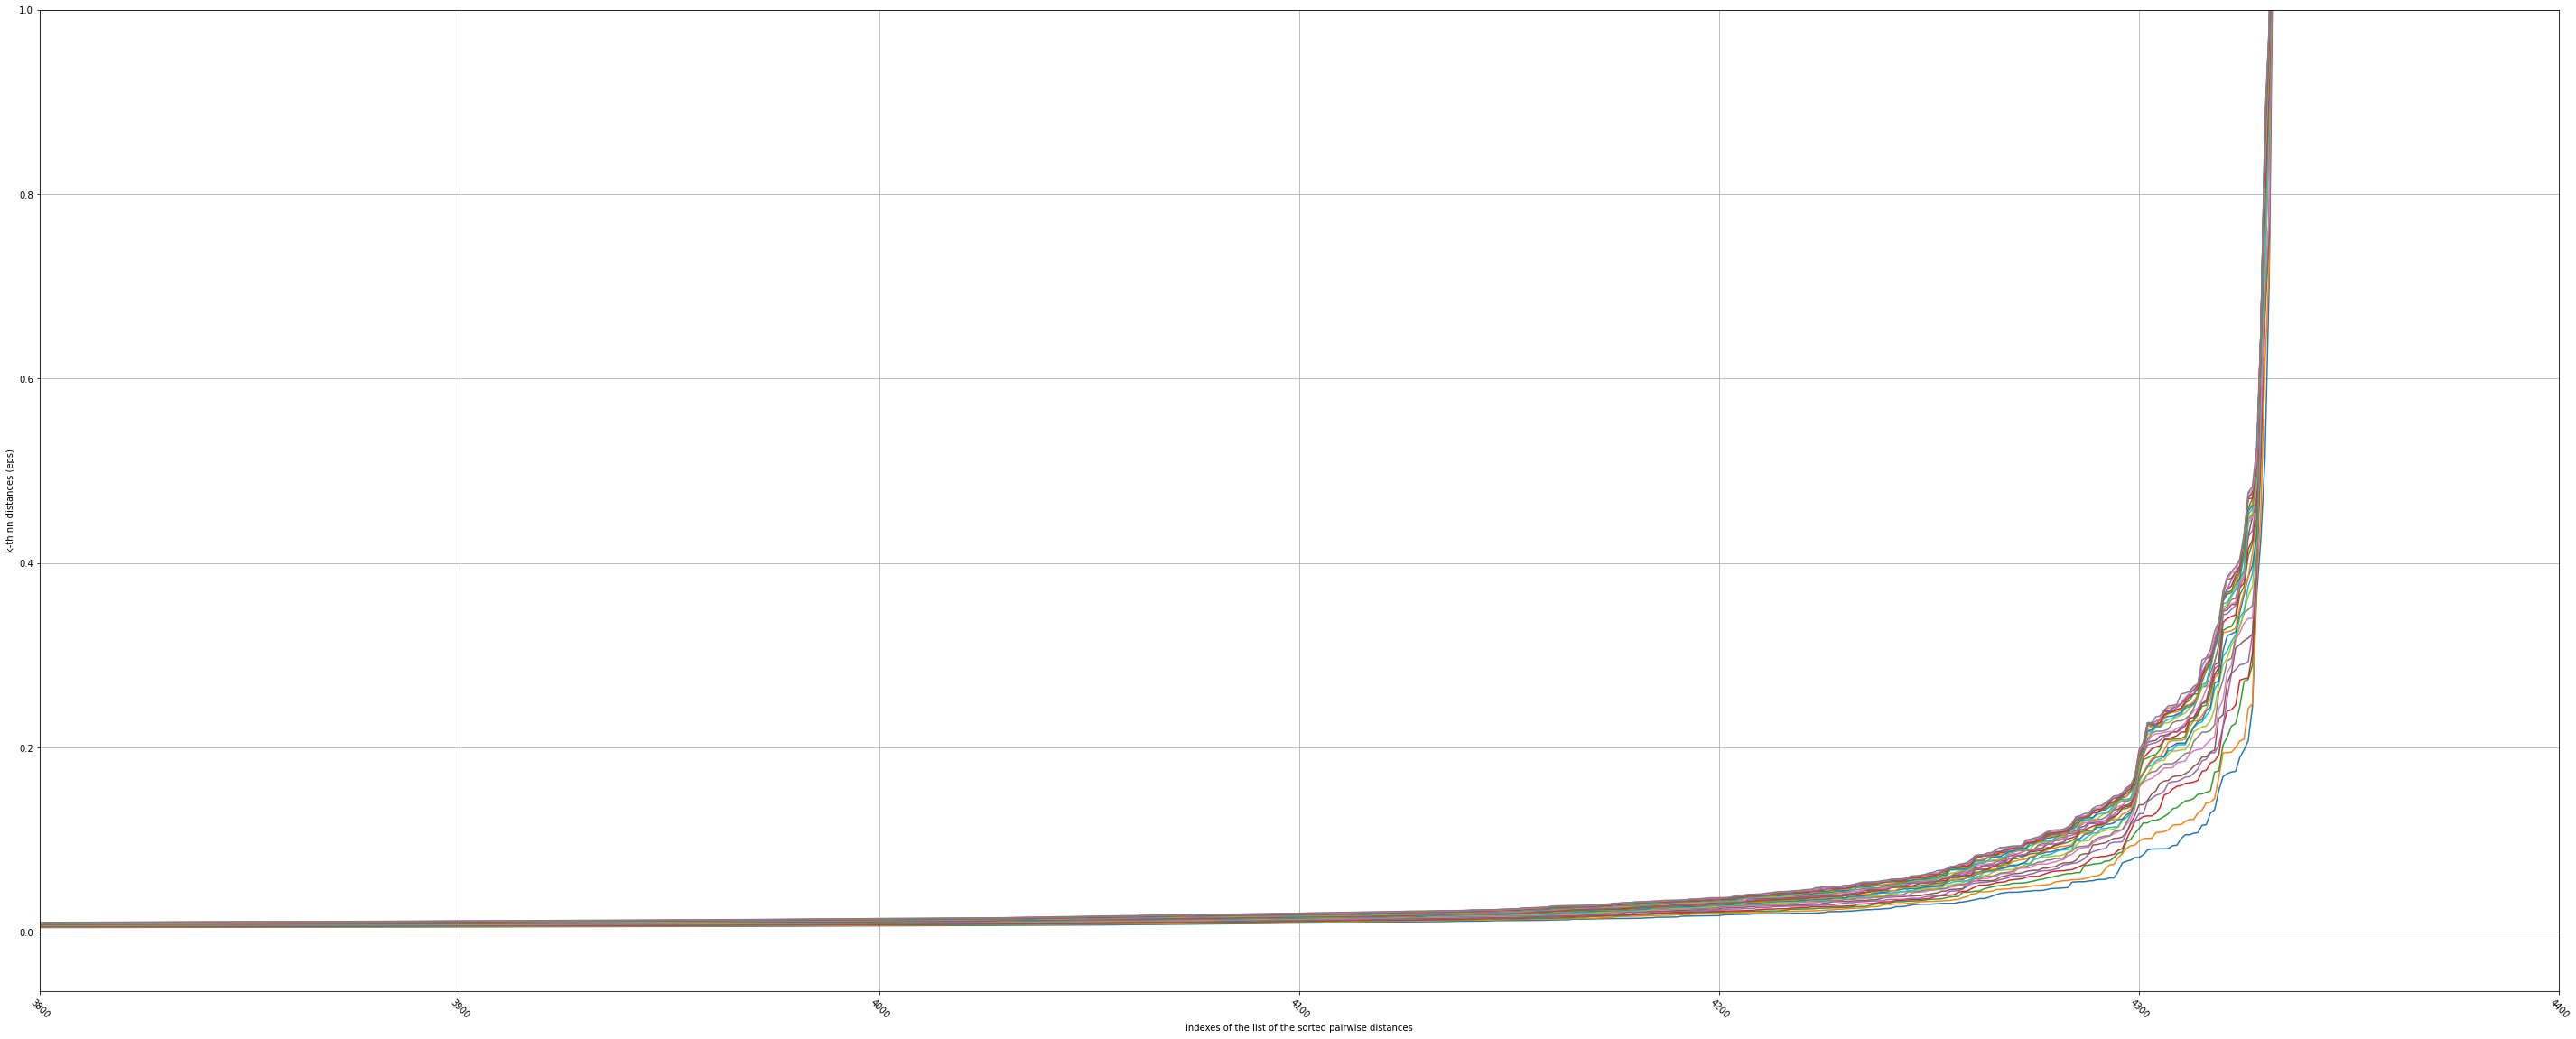

In [29]:
plt.figure(figsize=(50, 20))
for k in kth_distances.keys():
    plt.plot(range(0, len(kth_distances[k])), sorted(kth_distances[k]))
plt.xlim((3800, 4400))
plt.ylim(top=1)
plt.ylabel('k-th nn distances (eps)')
plt.xlabel('indexes of the list of the sorted pairwise distances')
plt.xticks(rotation=-45)
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()

Same plot with the median value of *[3800, Kmax]* for every x because the plot seems to followe the same behaviour for every K. (Just to have a cleaner view of the plot)

In [30]:
kmedian = list()
for i in tqdm(range(len(kth_distances[kmin])), total=len(kth_distances[kmin]), desc='Computing the median of the functions'):
    aux = list()
    for k in kth_distances.keys():
        aux.append(sorted(kth_distances[k])[i])
    kmedian.append(np.median(aux))

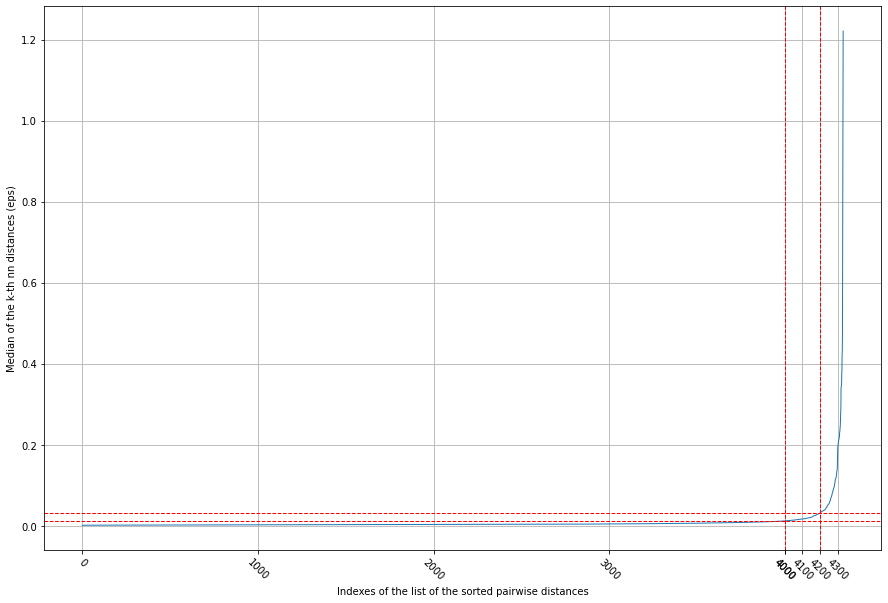

Elbow area of the median of kth-NN distances plot:
Low:	x = 4000 --> eps = 0.011832122874249798
High:	x = 4200 --> eps = 0.03131958136158988


In [31]:
plt.figure(figsize=(15,10))
plt.plot(range(0,len(kth_distances[kmin])), kmedian, linewidth=1) #kmedian already sorted
plt.ylabel('Median of the k-th nn distances (eps)')
plt.xlabel('Indexes of the list of the sorted pairwise distances')

xticks = []
for i in range(0, 4001, 1000): xticks.append(i)
for i in range(4000, len(kth_distances[kmin]), 100): xticks.append(i)
plt.xticks(xticks, rotation=-45)
plt.tick_params(axis='both', which='major')
plt.grid()
low_elb = 4000
high_elb = 4200
plt.axvline(x=low_elb, color='red', linestyle='--', linewidth=1)
plt.axhline(y=sorted(kmedian)[low_elb], color='red', linestyle='--', linewidth=1)
plt.axvline(x=high_elb, color='red', linestyle='--', linewidth=1)
plt.axhline(y=sorted(kmedian)[high_elb], color='red', linestyle='--', linewidth=1)
plt.show()
print("Elbow area of the median of kth-NN distances plot:")
print(f"Low:\tx = {low_elb} --> eps = {kmedian[low_elb]}")  # kmedian is already sorted
print(f"High:\tx = {high_elb} --> eps = {kmedian[high_elb]}")  # kmedian is already sorted

## Grid search for _eps_ and <i>min_samples</i>

In [32]:
# func to get metrics to evaluate the clustering done with certain eps and min_samples
def get_metrics(eps, ms, dataset, iter_):
    # Fitting
    dbscan = DBSCAN(eps=eps, min_samples=ms)
    dbscan.fit(dataset)
    # Mean Noise Point Distance metric
    noise_indices = (dbscan.labels_ == -1)  #list of booleans
    if True in noise_indices:
        nbrs = NearestNeighbors(n_neighbors = 10).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)   #returns indices of and distances to the neighbors of each point
        noise_distances = distances[noise_indices, 1 : ]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
    # silhouette score
    sil = silhouette_score(dataset, dbscan.labels_)
    # Number of found Clusters metric
    number_of_clusters = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))
    return noise_mean_distance, number_of_clusters, sil

In [33]:
# Lists for the params to test in the grid search
gs_eps_list = [round(eps, 3) for eps in np.arange(kmedian[low_elb], kmedian[high_elb], 0.001)]
gs_ms_list = range(kmin, 10, 1) # after k=9 we always get 1 cluster

print("Grid search parameters:")
print("eps:", gs_eps_list)
print("min_samples:", list(gs_ms_list))

Grid search parameters:
eps: [0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031]
min_samples: [3, 4, 5, 6, 7, 8, 9]


Dataframes to contain the results of the grid search

In [34]:
# Dataframe for the metric on the avg distance of the noise points from the K nearest ones
results_noise = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe for the metric on the number of clusters
results_clusters = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe to store the silhouette score for each combo in the grid search
results_silhouette = pd.DataFrame(
    data = np.zeros((len(gs_eps_list), len(gs_ms_list))),
    columns = gs_ms_list,
    index = gs_eps_list
)

### Grid search

In [35]:
i = 0
for eps in tqdm(gs_eps_list, total=len(gs_eps_list), desc='Proceeding of grid search'):
    for ms in gs_ms_list:
        i += 1
        # Compute metrics
        noise_metric, clusters_metric, sil_metric = get_metrics(eps, ms, df_norm, i)
        # Insert results in the apposite dataframes
        results_noise.loc[eps, ms] = noise_metric
        results_clusters.loc[eps, ms] = clusters_metric
        results_silhouette.loc[eps, ms] = sil_metric

Results of grid search:

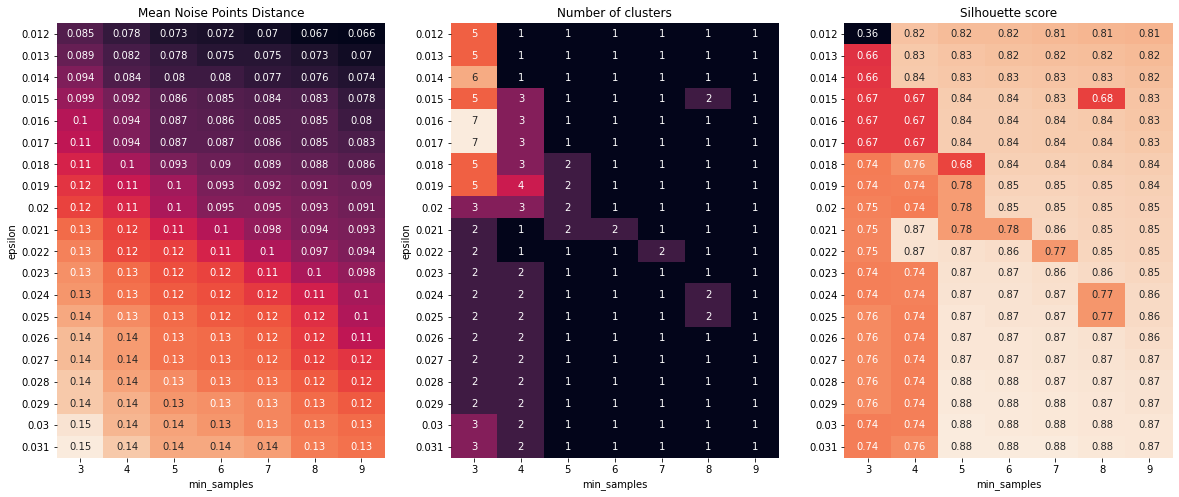

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("Number of clusters")
sns.heatmap(results_silhouette, annot=True, ax=ax3, cbar=False).set_title("Silhouette score")
ax1.set_xlabel("min_samples")
ax2.set_xlabel("min_samples")
ax3.set_xlabel("min_samples")
ax1.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
plt.show()

We choose *eps=0.02* and *min_samples=4* based on noise value analysis (remember one cluster is for unclassified points)

Clusters labels: [-1  0  1  2]
Elements per cluster: [  97 4223    4    9]
Silhouette score:  0.7393362524619327


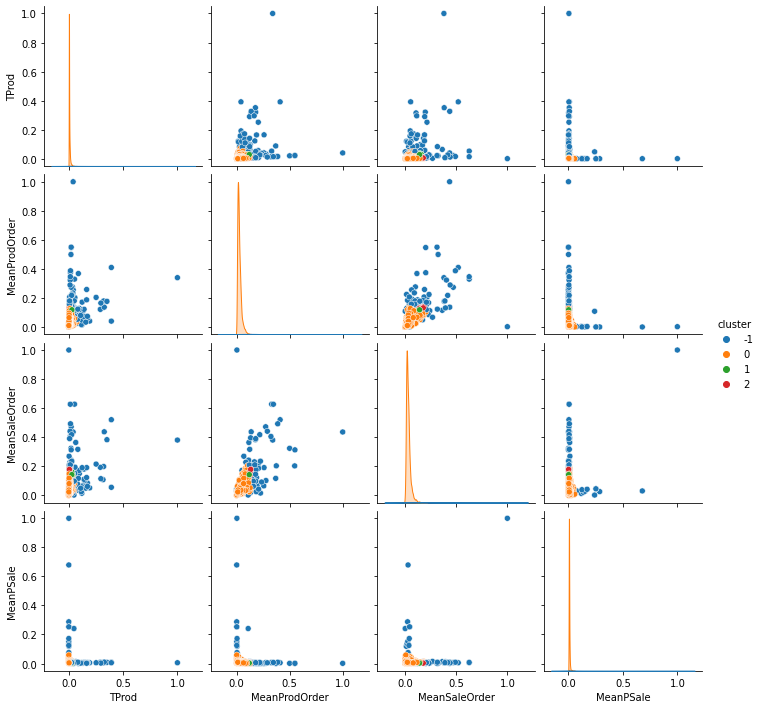

In [37]:
dbscan = DBSCAN(eps=0.02, min_samples=4).fit(df_norm)
results = np.unique(dbscan.labels_, return_counts=True)
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")
# Silhouette score
print("Silhouette score: ", silhouette_score(df_norm, dbscan.labels_))
# Extracting labels
ndf['cluster'] = dbscan.labels_
# Pairplot
sns.pairplot(ndf, hue='cluster', palette='tab10')
plt.show()

## Analyzing results

In [38]:
clust_list = list()
for i in tqdm(range(len(ndf['cluster'].unique())-1), total=len(ndf['cluster'].unique())-1, desc="Creating cluster dataframes"):
    clust_list.append(df_aux.iloc[list(ndf[ndf['cluster'] == i].index)])

Clusters labels: [-1  0  1  2]
Elements per cluster: [  97 4223    4    9]


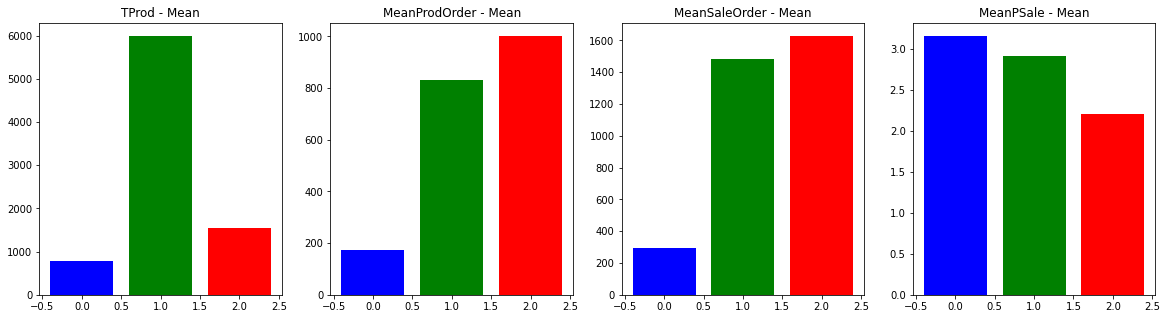

In [40]:
attr = df_aux.columns
clusters = range(len(clust_list)) # not-classified elements are not considered
fig, axs = plt.subplots(1,len(attr),figsize=(20,5))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for cluster_df in clust_list:
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index].bar(clusters, mean_values, color = ['b','g','r','y'])
    axs[attr_index].set_title(f"{attr[attr_index]} - Mean")
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")

In [41]:
# memory cleaning to avoid saturation
del dist, kmin, kmax, kth_distances, kmedian, xticks, low_elb, high_elb, gs_eps_list, gs_ms_list, results_noise
del results_clusters, results_silhouette, fig, ax1, ax2, ax3, dbscan, results, clust_list, attr, clusters, axs

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR9IawGaGT3e7eXNCxCk4UbFMXvygnOwOrnQg&usqp=CAU"/>

# Hierarchical Clustering

We decided to work on the same subset of attributes chosen for K-Means and DBSCAN

In [42]:
df_aux.head()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
CustomerID,,,,
17850,1702,48.629,151.940,3.960
13047,1355,84.688,193.069,3.926
12583,4978,292.824,389.961,2.140
13748,439,87.800,189.650,3.996
15100,58,9.667,105.850,10.950


Defining functions that will be useful for re-elaborate data and analyze results

In [43]:
# from the hierarchical clustering defined by the given linkage matrix and threshold return the cluster topology
def count_cluster_elements(data, threshold, criterion='distance'):
    count = {}
    clusters = fcluster(data, threshold, criterion)
    for c in clusters:
        count[c] = count[c]+1 if c in count else 1
    return count, clusters

# from flat clusters returns dictionary of dataframes representing the cluster
def get_dataframe(complete_df, flat_cluster):
    distinct_clusters = list(set(flat_cluster))
    sorted(distinct_clusters)
    cluster_index = {c:[] for c in distinct_clusters} 
    for i in range(len(flat_cluster)):
        cluster_index[flat_cluster[i]].append(i)
    clusters_df = {}
    indexes = df.index
    for c in distinct_clusters:
        elem = cluster_index[c]
        clusters_df[c] = df[df.index.isin([indexes[i] for i in elem])]
    return clusters_df

#plot values of elements in clusters
def plot_cluster_values(cdf, df_aux):
    attr = df_aux.columns
    clusters = [i for i in cdf]
    fig, axs = plt.subplots(1,len(attr),figsize=(20,5))
    for attr_index in range(len(attr)):
        mean_values = []
        max_values = []
        min_values = []
        for _, cluster_df in cdf.items():
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
            max_values.append(cluster_df.describe()[attr[attr_index]][7])
            min_values.append(cluster_df.describe()[attr[attr_index]][3])
        axs[attr_index].bar(clusters, mean_values, color = ['b','g','r','y'])
        axs[attr_index].set_title(f"{attr[attr_index]} - Mean")

### Complete - Euclidean

In this case we use *complete* in the computation of distance between clusters<br>
&nbsp; $d(u, v) = \max(dist(u[i],v[j]))$ <br>
We consider the distance equal to the *max* distance of two points in two different clusters

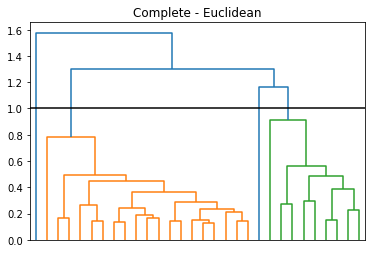

In [44]:
data_dist = pdist(df_norm, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
threshold_value = 1.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Complete - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [45]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
score = silhouette_score(df_norm, clusters)
print("Clusters:", len(conta.keys()), end=" - ")
print(list(reversed(sorted(conta.values()))))
print(f"Silhouette score: {score}")

Clusters: 4 - [4311, 20, 1, 1]
Silhouette score: 0.9229675968079302


[1:4311] [2:20] [3:1] [4:1] 

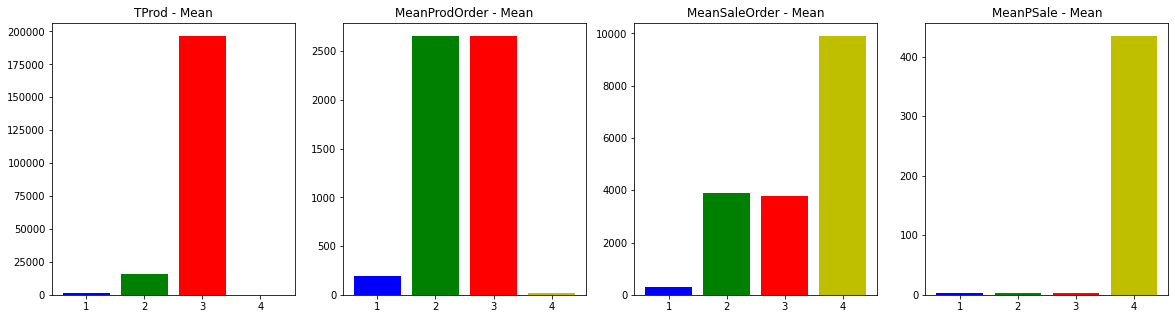

In [46]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [49]:
del data_dist, data_link, threshold_value, res, conta, clusters, score, cdf

### Single - Euclidean

In this case we use *single* in the computation of distance between clusters<br>
&nbsp; $d(u,v) = min(dist(u[i],v[j]))$ <br>
We consider the distance equal to the *min* distance of two points in two different clusters

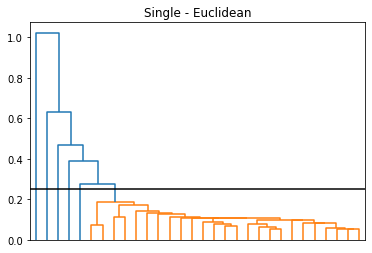

In [50]:
data_dist = pdist(df_norm, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
threshold_value = 0.25
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Single - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [51]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
score = silhouette_score(df_norm, clusters)
print("Clusters:", len(conta.keys()), end=" - ")
print(list(reversed(sorted(conta.values()))))
print(f"Silhouette score: {score}")

Clusters: 6 - [4328, 1, 1, 1, 1, 1]
Silhouette score: 0.9350227049491753


[1:4328] [2:1] [3:1] [4:1] [5:1] [6:1] 

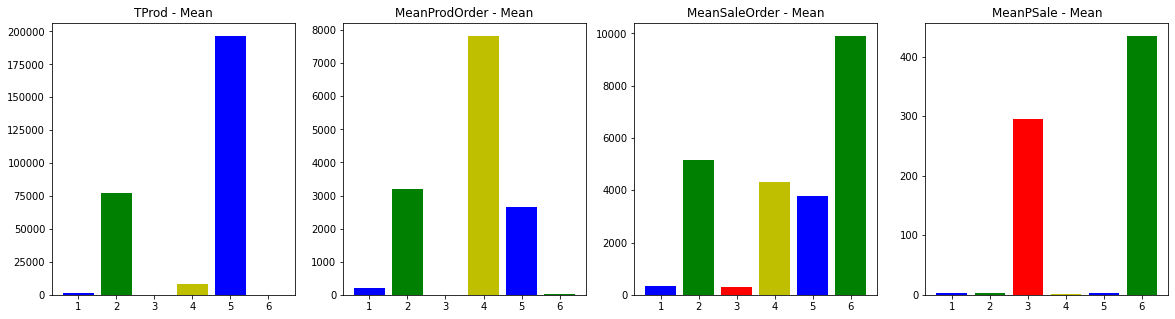

In [52]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [53]:
del data_dist, data_link, threshold_value, res, conta, clusters, score, cdf

### Average - Euclidean

In this case we use *average* in the computation of distance between clusters<br>
&nbsp; $d(u,v) = \sum_{ij} \frac{d(u[i], v[j])}{(|u|*|v|)}$ <br>
We consider the distance equal to the *average distance* of two points in two different clusters

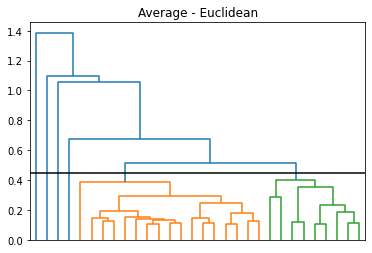

In [54]:
data_dist = pdist(df_norm, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
threshold_value = 0.45
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Average - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [55]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
score = silhouette_score(df_norm, clusters)
print("Clusters:", len(conta.keys()), end=" - ")
print(list(reversed(sorted(conta.values()))))
print(f"Silhouette score: {score}")

Clusters: 6 - [4312, 17, 1, 1, 1, 1]
Silhouette score: 0.9206974421486209


[1:4312] [2:17] [3:1] [4:1] [5:1] [6:1] 

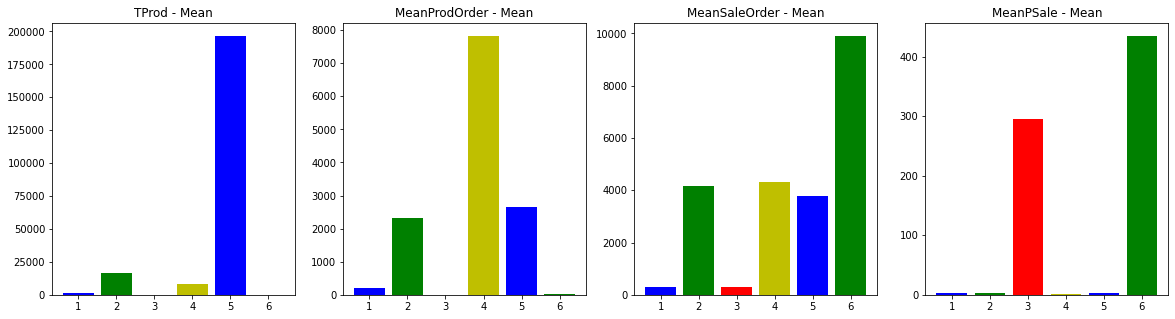

In [56]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [57]:
del data_dist, data_link, threshold_value, res, conta, clusters, score, cdf

### Ward - Euclidean

In this case we use *ward* in the computation of distance between clusters<br>
&nbsp;$d(u,v) = \sqrt{\frac{|v|+|s|}{T}d(v,s)^2+ \frac{|v|+|t|}{T}d(v,t)^2- \frac{|v|}{T}d(s,t)^2}$ <br>
In this case differently from the previous ones we use a statistical approach, in fact *ward* is based on **Ward variance minimization algorithm**. <br>
The distance of two cluster *u,v* is equal to the variance of the distances of the clusters *s,t* that are joined to create *u* and the cluster *v*.

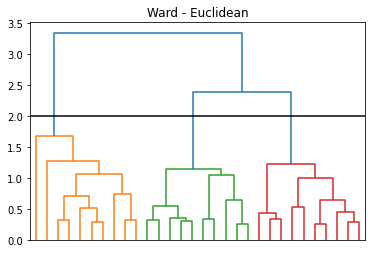

In [58]:
data_dist = pdist(df_norm, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
threshold_value = 2.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Ward - Euclidean")
plt.axhline(y=threshold_value, color="black")

We can see from the dendrogram that the cluster on the left has a singleton which is merged with other elements. <br>
This recalls an aspect we have already highlighted before, there is a point which is an extreme outlier with respect to the metrics.

In [59]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
score = silhouette_score(df_norm, clusters)
print("Clusters:", len(conta.keys()), end=" - ")
print(list(reversed(sorted(conta.values()))))
print(f"Silhouette score: {score}")

Clusters: 3 - [3853, 458, 22]
Silhouette score: 0.6717133967267056


[1:22] [2:3853] [3:458] 

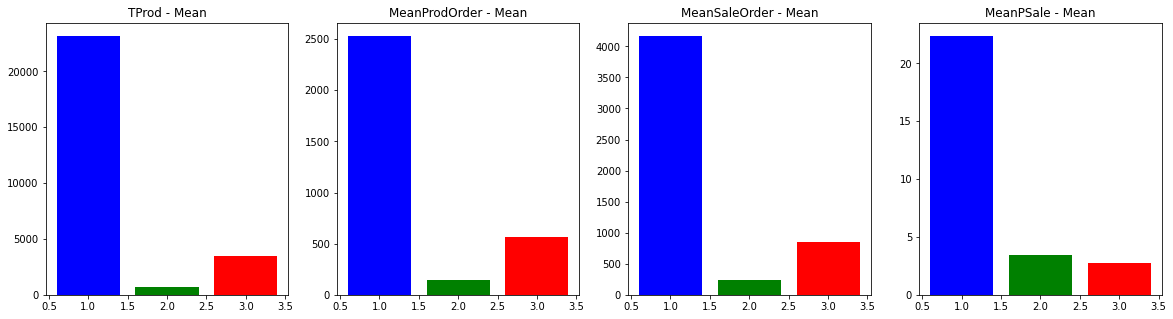

In [60]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [61]:
del data_dist, data_link, threshold_value, res, conta, clusters, score, cdf

Let's now analyze the result considering the outlier sample as an "outlier cluster"

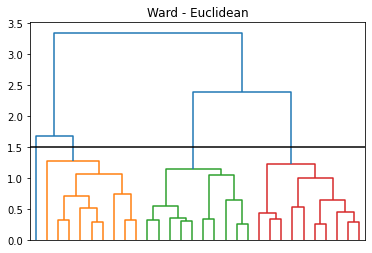

In [62]:
data_dist = pdist(df_norm, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
threshold_value = 1.5
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Ward - Euclidean")
plt.axhline(y=threshold_value, color="black")

In [63]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
score = silhouette_score(df_norm, clusters)
print("Clusters:", len(conta.keys()), end=" - ")
print(list(reversed(sorted(conta.values()))))
print(f"Silhouette score: {score}")

Clusters: 4 - [3853, 458, 21, 1]
Silhouette score: 0.6721013455064441


[1:21] [2:1] [3:3853] [4:458] 

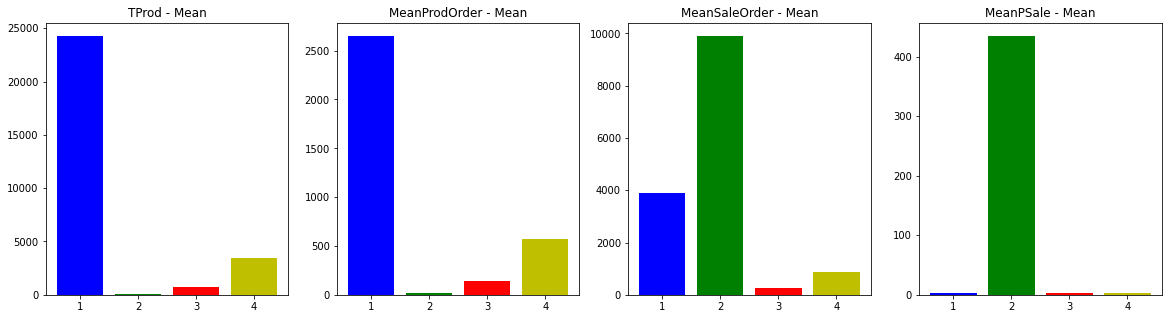

In [64]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

[1:21] [3:3853] [4:458] 

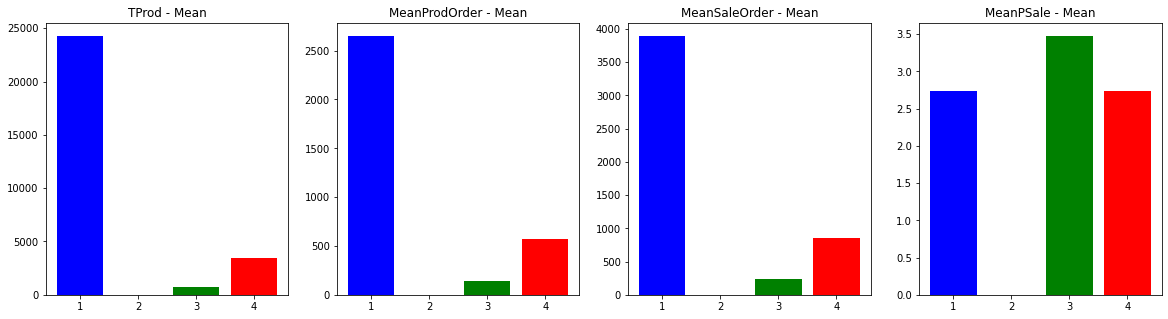

In [65]:
to_remove = [c for c,df in cdf.items() if len(df) == 1]
del[cdf[to_remove[0]]]
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [66]:
del data_dist, data_link, threshold_value, res, conta, clusters, score, cdf

### Agglomerative Clustering

In [67]:
def agg_clust(data, method):
    print(f"### {method} - euclidean ###", end="\n\n")
    for i in range(3, 5):
        complete = AgglomerativeClustering(n_clusters=i, linkage=method, affinity='euclidean', connectivity=None)
        complete.fit(data)
        hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
        print('Numero Cluster: ', i)
        print('Cluster', dict(zip(bins, hist)))
        print('Silhouette Score', silhouette_score(data, complete.labels_))
    print()

In [68]:
agg_clust(df_norm, "complete")
agg_clust(df_norm, "single")
agg_clust(df_norm, "average")
agg_clust(df_norm, "ward")

### complete - euclidean ###

Numero Cluster:  3
Cluster {0: 21, 1: 1, 2: 4311}
Silhouette Score 0.9265553774017546
Numero Cluster:  4
Cluster {0: 20, 1: 1, 2: 4311, 3: 1}
Silhouette Score 0.9229675968079302

### single - euclidean ###

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.9604297674001191
Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502745851489

### average - euclidean ###

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.9604297674001191
Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502745851489

### ward - euclidean ###

Numero Cluster:  3
Cluster {0: 22, 1: 458, 2: 3853}
Silhouette Score 0.6717133967267056
Numero Cluster:  4
Cluster {0: 21, 1: 458, 2: 3853, 3: 1}
Silhouette Score 0.6721013455064441



We can see that either we consider the *divisive* or *agglomerative* approach we get the same results.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR9IawGaGT3e7eXNCxCk4UbFMXvygnOwOrnQg&usqp=CAU"/>

# Fuzzy C-Means

Fuzzy C-Means is a *soft-clustering* method in which each element can belong to different clusters.<br>
The algorithm will compute a *membership value* for each point with respect to all the clusters and assign the sample to the cluster with highest membership.<br>
The initialization is very similar to K-Means in fact it starts with some centroids and then updates them at each iteration recomputing membership values.

In [69]:
# defining some functions that will help in handling and plotting results
def get_dataframe(complete_df, flat_cluster):
    distinct_clusters = list(set(flat_cluster))
    sorted(distinct_clusters)
    cluster_index = {c:[] for c in distinct_clusters} 
    for i in range(len(flat_cluster)):
        cluster_index[flat_cluster[i]].append(i)
    clusters_df = {}
    indexes = df.index
    for c in distinct_clusters:
        elem = cluster_index[c]
        clusters_df[c] = df[df.index.isin([indexes[i] for i in elem])]
    return clusters_df

def plot_cluster_values(cdf, df_aux):
    attr = df_aux.columns
    clusters = [i for i in cdf]
    fig, axs = plt.subplots(1,len(attr),figsize=(20,5))
    for attr_index in range(len(attr)):
        mean_values = []
        max_values = []
        min_values = []
        for _, cluster_df in cdf.items():
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
            max_values.append(cluster_df.describe()[attr[attr_index]][7])
            min_values.append(cluster_df.describe()[attr[attr_index]][3])
        axs[attr_index].bar(clusters, mean_values, color = ['b','g','r','y'])
        axs[attr_index].set_title(f"{attr[attr_index]} - Mean")
        
def get_clusters(clusters, ignore=[]):
    cust_clust = {}
    for i in range(len(clusters)):
        for customer in clusters[i]:
            if customer not in ignore:
                cust_clust[customer] = i
    clustering = []
    for cust in sorted(cust_clust):
        clustering.append(cust_clust[cust])
    return clustering

Given the results obtained from previous clustering approaches we decided to apply Fuzzy C-Means with *3-4* clusters.

In [70]:
# initialize centroids
initial_centers = kmeans_plusplus_initializer(df_norm, 4, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(df_norm, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

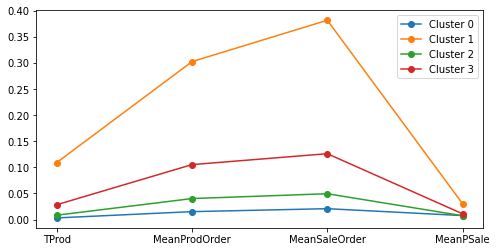

In [71]:
# normalized centers
label_s = 10
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

Text(0.5, 0, 'MeanSaleOrder')

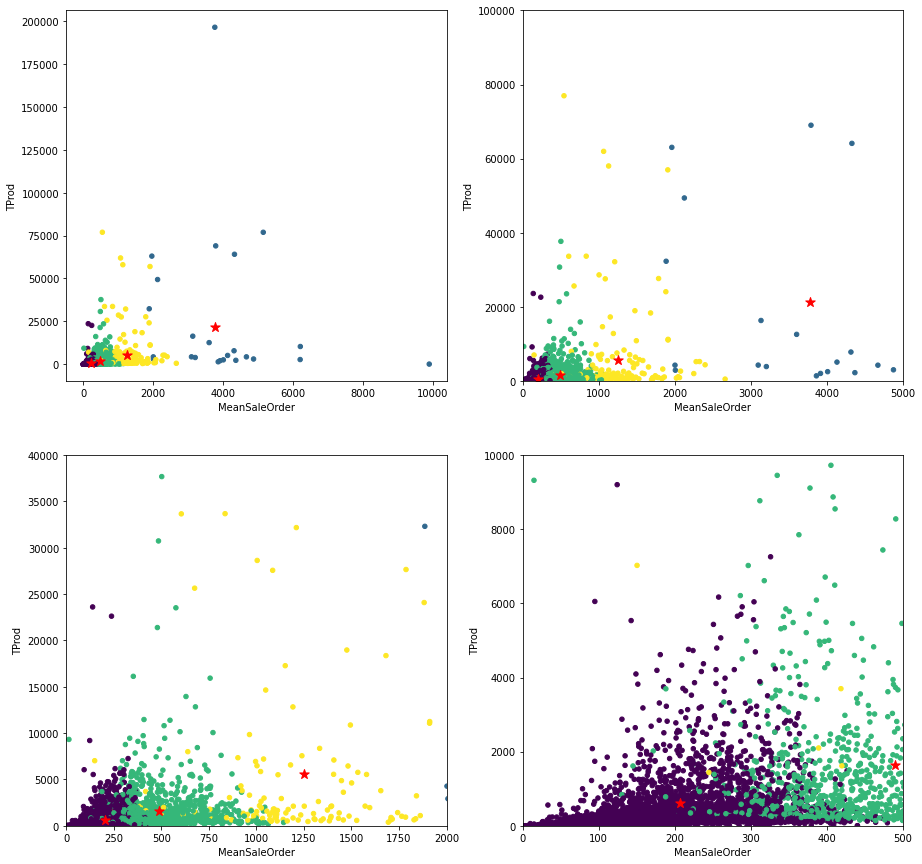

In [72]:
cl = get_clusters(clusters)
center_norm = scaler.inverse_transform(centers)
fig, axs = plt.subplots(2,2,figsize=(15,15))
label_s = 10
col1, i1 = df_aux['MeanSaleOrder'], 2
col2, i2 = df_aux['TProd'], 0
axs[0][0].scatter(col1, col2, c=cl, s=20)
axs[0][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[0][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[0][1].set_xlim((0,5000))
axs[0][1].set_ylim((0,100000))
axs[0][1].scatter(col1, col2, c=cl, s=20)
axs[0][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[0][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[1][0].set_xlim((0,2000))
axs[1][0].set_ylim((0,40000))
axs[1][0].scatter(col1, col2, c=cl, s=20)
axs[1][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[1][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[1][1].set_xlim((0,500))
axs[1][1].set_ylim((0,10000))
axs[1][1].scatter(col1, col2, c=cl, s=20)
axs[1][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[1][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

In [73]:
l = get_clusters(clusters)
print("Silhouette score: ", silhouette_score(df_norm, l))
print('Davies-Bouldin score: ', davies_bouldin_score(df_norm, l))

Silhouette score:  0.49756186359212995
Davies-Bouldin score:  0.973474224933508


[0:3086] [1:24] [2:1086] [3:137] 

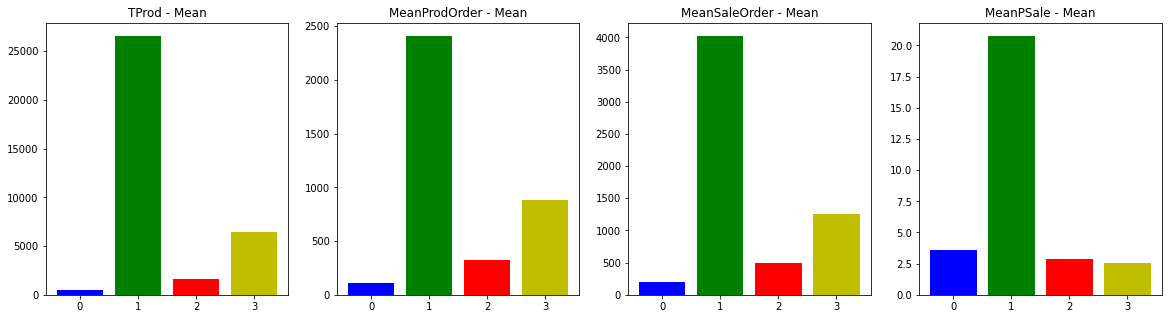

In [74]:
cdf = get_dataframe(df, get_clusters(clusters))
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

We get similar results as K-Means with 4 clusters. <br>
We can see how the smaller cluster is the one that contains elements that are further from the majority of data.<br>
Next we are going to analyze Fuzzy C-Means with 3 clusters keeping in mind the outlier point we discoverd ealier.

In [75]:
initial_centers = kmeans_plusplus_initializer(df_norm, 3, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
fcm_instance = fcm(df_norm, initial_centers)
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

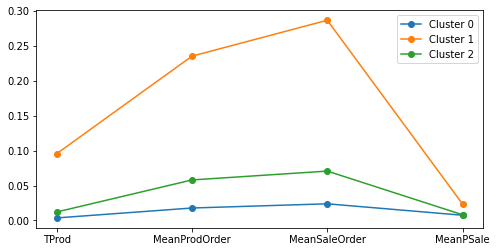

In [76]:
# normalized centers
label_s = 10
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

Text(0.5, 0, 'MeanSaleOrder')

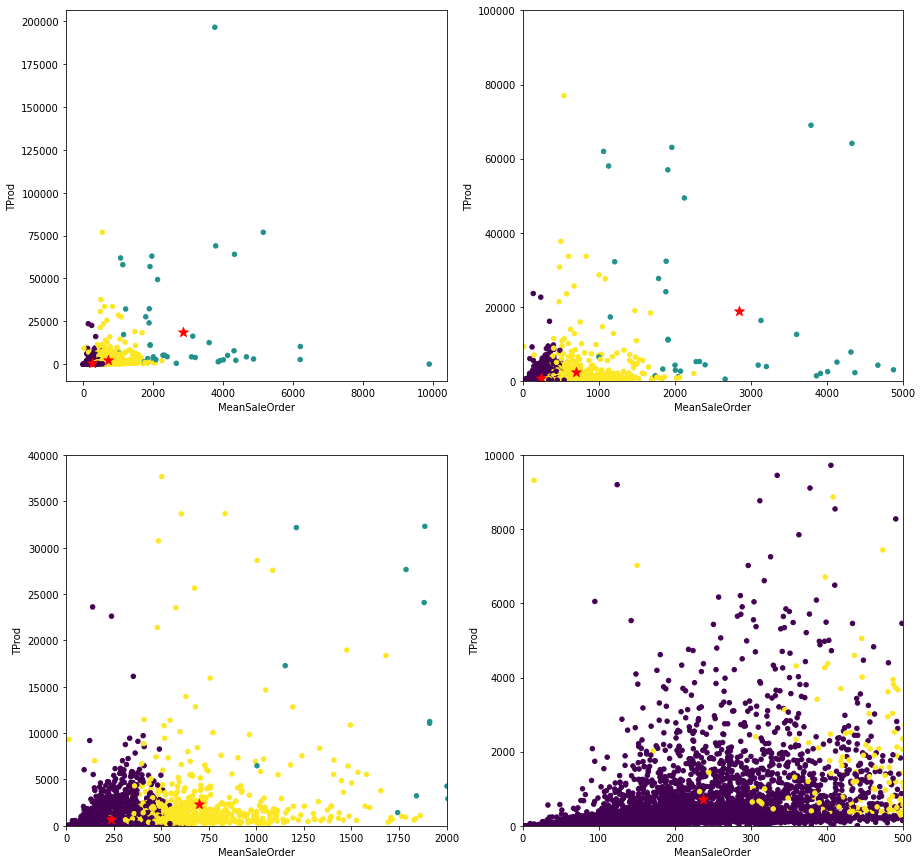

In [77]:
cl = get_clusters(clusters)
center_norm = scaler.inverse_transform(centers)
fig, axs = plt.subplots(2,2,figsize=(15,15))
label_s = 10
col1, i1 = df_aux['MeanSaleOrder'], 2
col2, i2 = df_aux['TProd'], 0
axs[0][0].scatter(col1, col2, c=cl, s=20)
axs[0][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[0][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[0][1].set_xlim((0,5000))
axs[0][1].set_ylim((0,100000))
axs[0][1].scatter(col1, col2, c=cl, s=20)
axs[0][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[0][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[1][0].set_xlim((0,2000))
axs[1][0].set_ylim((0,40000))
axs[1][0].scatter(col1, col2, c=cl, s=20)
axs[1][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[1][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

axs[1][1].set_xlim((0,500))
axs[1][1].set_ylim((0,10000))
axs[1][1].scatter(col1, col2, c=cl, s=20)
axs[1][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
axs[1][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

In [78]:
# removing from the elements the outlier point to get a better plot and indicators value
skip = list(df.index).index(15098)
X = np.delete(df_norm, [skip], axis=0)
l = get_clusters(clusters, ignore=[skip])
print("Silhouette score: ", silhouette_score(X, l))
print('Davies-Bouldin score: ', davies_bouldin_score(X, l))

Silhouette score:  0.6206755907312664
Davies-Bouldin score:  0.8650914791834757


[0:3681] [1:41] [2:610] 

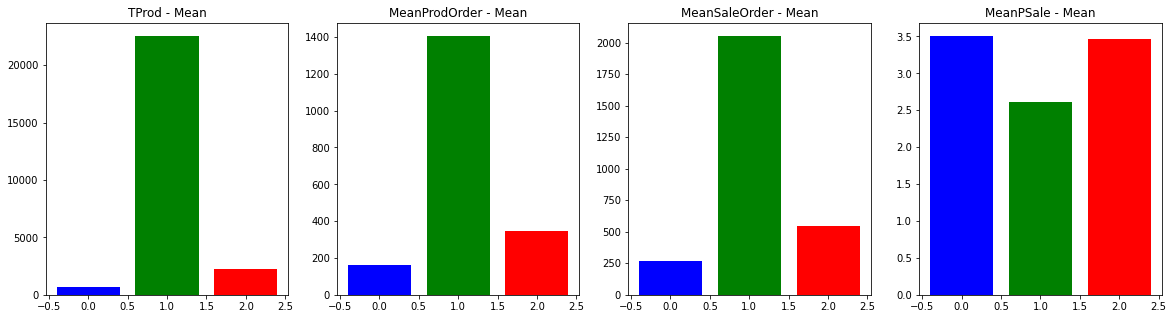

In [79]:
cdf = get_dataframe(df, get_clusters(clusters, ignore=[skip]))
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [80]:
# memory cleaning to avoid saturation
del initial_centers, fcm_instance, clusters, centers, label_s, cl, center_norm, fig, axs, col1, i1, col2, i2, l, cdf, skip, X

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR9IawGaGT3e7eXNCxCk4UbFMXvygnOwOrnQg&usqp=CAU"/>

# Genetic Algorithms Clustering

This type of clustering algorithm tries to exploit the ability of exploration of Genetic Algorithms to find the best clustering over the dataset.<br>
Each population is composed of different clustering possibilities. The best ones are then crossovered to obtain the new child model for the next generation.<br>
Repeating this process for a fixed number of iteration we get the clustering that minimizes the fitting function, which in this implementation is based on variance.

In [8]:
def ga_cluster(sample, nc, cc, pc, mg):
    observer_instance = ga_observer(True, True, True)
    ga_instance = genetic_algorithm(data=sample, count_clusters=nc, chromosome_count=cc, population_count=pc,count_mutation_gens=mg,observer=observer_instance)
    ga_instance.process()
    clusters = ga_instance.get_clusters()
    print([len(c) for c in clusters])    
    clusters_df = {}
    indexes = df.index
    for i in range(len(clusters)):
        clusters_df[i] = df[df.index.isin([indexes[i] for i in clusters[i]])]
    attr = df_aux.columns
    mean_values_to_plot= {a:[] for a in attr}
    to_plot = [[x[1],x[2]] for x in sample]
    for attr_index in range(len(attr)):
        mean_values = []
        for _, cluster_df in clusters_df.items():
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        mean_values_to_plot[attr[attr_index]] = mean_values
    ga_visualizer.show_clusters(to_plot, observer_instance)
    return mean_values_to_plot, clusters

def calc_silhouette(data, clusters):
    cust_clust = {}
    for i in range(len(clusters)):
        for customer in clusters[i]:
            cust_clust[customer] = i
    clustering = []
    for cust in sorted(cust_clust):
        clustering.append(cust_clust[cust])
    print("Silhouette score: ", silhouette_score(data, clustering))
    return clustering

def plot_stats(means, cl):
    attr = df_aux.columns
    clusters = [i for i in range(len(cl))]
    colors = ["red", "blue", "green", "yellow", "orange", "brown", "purple", "pink"]
    fig, axs = plt.subplots(1, len(attr),figsize=(20,5))
    for attr_index in range(len(attr)):
        axs[attr_index].bar(clusters, means[attr[attr_index]], color=colors[:len(clusters)])
        axs[attr_index].set_title(f"{attr[attr_index]} - Mean")

def plot_dist(df_aux, clustering):
    fig, axs = plt.subplots(2,2,figsize=(15,15))
    label_s = 10
    col1, i1 = df_aux['MeanSaleOrder'], 2
    col2, i2 = df_aux['TProd'], 0

    axs[0][0].scatter(col1, col2, c=clustering, s=20)
    axs[0][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
    axs[0][0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
    axs[0][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

    axs[0][1].set_xlim((0,5000))
    axs[0][1].set_ylim((0,100000))
    axs[0][1].scatter(col1, col2, c=clustering, s=20)
    axs[0][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
    axs[0][1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
    axs[0][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

    axs[1][0].set_xlim((0,2000))
    axs[1][0].set_ylim((0,40000))
    axs[1][0].scatter(col1, col2, c=clustering, s=20)
    axs[1][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
    axs[1][0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1][0].set_ylabel(df_aux.columns[i2], fontsize=label_s)
    axs[1][0].set_xlabel(df_aux.columns[i1], fontsize=label_s)

    axs[1][1].set_xlim((0,500))
    axs[1][1].set_ylim((0,10000))
    axs[1][1].scatter(col1, col2, c=clustering, s=20)
    axs[1][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
    axs[1][1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1][1].set_ylabel(df_aux.columns[i2], fontsize=label_s)
    axs[1][1].set_xlabel(df_aux.columns[i1], fontsize=label_s)

[1442, 1510, 1381]


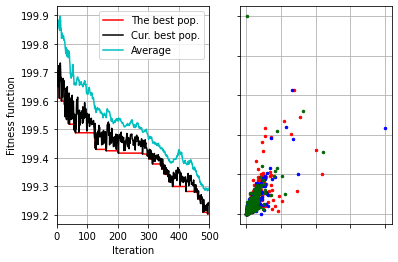

In [9]:
nc = 3
pc = 500
cc = 50
mg = 5
mv, cl = ga_cluster(df_norm, nc, cc, pc, mg)

Silhouette score:  -0.04271412575094203


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [[0, 5, 7, 9, 12, 16, 19, 21, 32, 41, 42, 45, 53, 60, 61, 69, 70, 71, 72, 73, 74, 76, 82, 86, 87, 88, 95, 97, 109, 111, 112, 114, 116, 120, 121, 127, 129, 134, 136, 139, 141, 143, 144, 150, 156, 157, 161, 162, 164, 166, 167, 175, 176, 177, 178, 179, 180, 183, 184, 187, 192, 194, 195, 196, 198, 199, 200, 202, 205, 207, 209, 211, 213, 216, 225, 226, 229, 234, 236, 237, 238, 241, 243, 246, 247, 248, 250, 252, 253, 255, 256, 258, 261, 263, 270, 272, 273, 274, 281, 284, 292, 295, 300, 304, 305, 306, 307, 311, 312, 321, 322, 324, 325, 326, 328, 333, 334, 335, 337, 339, 341, 342, 344, 348, 351, 352, 358, 360, 370, 373, 375, 376, 379, 396, 398, 400, 401, 402, 404, 408, 410, 411, 412, 413, 414, 420, 423, 425, 426, 431, 433, 434, 435, 438, 439, 440, 441, 442, 444, 445, 448, 449, 451, 452, 454, 455, 456, 457, 459, 460, 462, 464, 466, 467, 468, 477, 479, 480, 483, 489, 492, 493, 494, 504, 506, 508, 516, 519, 525, 527, 532, 533, 536, 538, 540, 541, 544, 545, 548, 550, 555, 558, 562, 565, 567, 568, 569, 571, 574, 575, 576, 577, 579, 582, 584, 587, 588, 589, 592, 593, 594, 596, 597, 602, 605, 606, 607, 613, 614, 620, 622, 634, 640, 648, 650, 651, 653, 654, 659, 663, 667, 668, 669, 671, 672, 676, 678, 681, 684, 694, 697, 700, 703, 709, 710, 712, 713, 715, 730, 732, 733, 734, 740, 742, 745, 750, 751, 754, 756, 757, 762, 763, 767, 776, 778, 779, 781, 790, 794, 795, 796, 797, 815, 816, 818, 819, 822, 824, 826, 833, 835, 836, 841, 844, 845, 852, 853, 858, 859, 860, 861, 862, 863, 864, 873, 874, 880, 883, 886, 887, 891, 892, 893, 895, 898, 899, 902, 903, 905, 911, 912, 913, 914, 926, 929, 930, 932, 933, 935, 939, 942, 943, 947, 949, 951, 952, 954, 959, 962, 964, 966, 968, 975, 978, 984, 990, 993, 997, 999, 1004, 1006, 1007, 1009, 1016, 1018, 1025, 1032, 1039, 1040, 1041, 1043, 1045, 1051, 1052, 1054, 1058, 1059, 1060, 1061, 1064, 1065, 1069, 1074, 1077, 1080, 1081, 1085, 1086, 1087, 1089, 1093, 1094, 1095, 1097, 1098, 1103, 1109, 1120, 1124, 1125, 1126, 1127, 1130, 1133, 1134, 1136, 1137, 1140, 1141, 1142, 1145, 1150, 1152, 1153, 1155, 1159, 1163, 1165, 1169, 1177, 1178, 1179, 1182, 1183, 1190, 1191, 1197, 1201, 1202, 1208, 1209, 1212, 1213, 1215, 1218, 1225, 1226, 1228, 1230, 1236, 1237, 1239, 1242, 1245, 1247, 1249, 1255, 1262, 1266, 1269, 1273, 1276, 1279, 1280, 1283, 1288, 1289, 1290, 1294, 1296, 1301, 1304, 1306, 1308, 1309, 1314, 1318, 1322, 1324, 1328, 1329, 1330, 1338, 1342, 1347, 1348, 1350, 1353, 1356, 1361, 1363, 1364, 1365, 1367, 1369, 1370, 1371, 1378, 1379, 1380, 1382, 1383, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1397, 1398, 1400, 1403, 1406, 1408, 1424, 1426, 1427, 1431, 1432, 1433, 1434, 1435, 1436, 1440, 1441, 1443, 1444, 1445, 1446, 1447, 1454, 1465, 1472, 1473, 1475, 1476, 1479, 1480, 1485, 1486, 1489, 1501, 1505, 1507, 1509, 1510, 1514, 1517, 1518, 1519, 1520, 1522, 1524, 1526, 1529, 1533, 1536, 1537, 1538, 1540, 1544, 1545, 1546, 1553, 1554, 1555, 1556, 1557, 1560, 1565, 1566, 1567, 1568, 1569, 1571, 1572, 1573, 1574, 1576, 1579, 1586, 1588, 1592, 1596, 1597, 1602, 1606, 1607, 1608, 1611, 1614, 1615, 1617, 1619, 1624, 1626, 1629, 1633, 1634, 1639, 1640, 1647, 1652, 1656, 1658, 1659, 1664, 1669, 1674, 1675, 1679, 1681, 1686, 1688, 1689, 1691, 1692, 1693, 1697, 1699, 1705, 1710, 1711, 1712, 1713, 1718, 1720, 1727, 1729, 1731, 1732, 1734, 1735, 1739, 1741, 1744, 1745, 1749, 1751, 1753, 1759, 1764, 1767, 1768, 1773, 1775, 1777, 1791, 1792, 1793, 1794, 1795, 1801, 1802, 1808, 1810, 1815, 1817, 1820, 1822, 1825, 1827, 1832, 1834, 1835, 1837, 1843, 1846, 1847, 1849, 1857, 1858, 1864, 1868, 1872, 1873, 1874, 1882, 1883, 1886, 1888, 1891, 1894, 1896, 1898, 1899, 1907, 1908, 1912, 1917, 1921, 1922, 1924, 1927, 1938, 1942, 1943, 1947, 1950, 1951, 1955, 1965, 1972, 1977, 1978, 1981, 1984, 1986, 1993, 1995, 1996, 1998, 2002, 2004, 2006, 2007, 2010, 2019, 2022, 2024, 2026, 2032, 2033, 2034, 2035, 2037, 2038, 2045, 2046, 2047, 2052, 2053, 2055, 2058, 2060, 2063, 2064, 2065, 2066, 2068, 2072, 2073, 2079, 2087, 2088, 2090, 2091, 2093, 2095, 2096, 2100, 2112, 2114, 2118, 2121, 2133, 2135, 2140, 2141, 2151, 2154, 2155, 2162, 2164, 2168, 2169, 2175, 2184, 2186, 2187, 2189, 2192, 2193, 2200, 2201, 2206, 2211, 2212, 2214, 2219, 2220, 2223, 2225, 2229, 2232, 2233, 2235, 2237, 2238, 2239, 2241, 2247, 2248, 2250, 2254, 2267, 2268, 2269, 2272, 2273, 2276, 2281, 2282, 2287, 2301, 2303, 2310, 2313, 2315, 2316, 2317, 2318, 2320, 2321, 2325, 2326, 2327, 2328, 2334, 2337, 2340, 2343, 2348, 2350, 2355, 2356, 2360, 2361, 2365, 2372, 2374, 2375, 2376, 2389, 2390, 2397, 2398, 2399, 2405, 2407, 2414, 2417, 2419, 2420, 2422, 2425, 2427, 2428, 2429, 2434, 2437, 2439, 2442, 2448, 2451, 2452, 2456, 2459, 2465, 2466, 2471, 2474, 2475, 2478, 2479, 2482, 2484, 2485, 2492, 2494, 2496, 2497, 2503, 2504, 2510, 2511, 2513, 2514, 2515, 2516, 2519, 2523, 2526, 2529, 2530, 2532, 2540, 2542, 2545, 2547, 2558, 2559, 2561, 2562, 2563, 2564, 2570, 2572, 2574, 2577, 2580, 2585, 2595, 2596, 2601, 2608, 2613, 2620, 2625, 2627, 2638, 2640, 2647, 2650, 2656, 2660, 2663, 2673, 2676, 2677, 2687, 2691, 2696, 2699, 2700, 2702, 2703, 2705, 2711, 2717, 2721, 2723, 2726, 2729, 2733, 2739, 2740, 2741, 2743, 2749, 2750, 2751, 2752, 2754, 2756, 2757, 2761, 2762, 2763, 2767, 2776, 2777, 2779, 2784, 2786, 2790, 2791, 2793, 2796, 2797, 2805, 2806, 2812, 2814, 2820, 2832, 2833, 2834, 2842, 2845, 2846, 2848, 2851, 2852, 2853, 2856, 2858, 2859, 2860, 2862, 2863, 2865, 2867, 2873, 2875, 2877, 2879, 2891, 2905, 2909, 2914, 2923, 2928, 2930, 2931, 2937, 2938, 2939, 2940, 2943, 2944, 2945, 2947, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2961, 2962, 2965, 2967, 2968, 2975, 2980, 2982, 2984, 2985, 2990, 2998, 3005, 3007, 3012, 3013, 3014, 3019, 3022, 3023, 3024, 3028, 3032, 3033, 3035, 3037, 3041, 3045, 3050, 3056, 3057, 3063, 3067, 3071, 3074, 3075, 3079, 3082, 3083, 3086, 3089, 3091, 3099, 3103, 3112, 3116, 3122, 3124, 3125, 3127, 3130, 3133, 3134, 3140, 3151, 3153, 3156, 3158, 3159, 3162, 3164, 3166, 3167, 3168, 3174, 3178, 3179, 3184, 3186, 3192, 3193, 3194, 3202, 3205, 3214, 3217, 3225, 3226, 3227, 3228, 3231, 3236, 3240, 3241, 3242, 3254, 3255, 3256, 3263, 3271, 3272, 3277, 3281, 3283, 3288, 3291, 3292, 3295, 3296, 3297, 3301, 3302, 3303, 3305, 3306, 3312, 3313, 3315, 3325, 3327, 3328, 3329, 3331, 3340, 3341, 3342, 3349, 3355, 3357, 3359, 3362, 3364, 3365, 3367, 3368, 3371, 3372, 3378, 3388, 3390, 3391, 3400, 3402, 3405, 3407, 3408, 3409, 3411, 3420, 3425, 3429, 3432, 3438, 3439, 3440, 3441, 3442, 3445, 3448, 3451, 3452, 3453, 3459, 3460, 3463, 3465, 3467, 3469, 3470, 3471, 3472, 3473, 3476, 3477, 3482, 3483, 3485, 3488, 3490, 3494, 3495, 3496, 3500, 3502, 3504, 3514, 3516, 3525, 3529, 3533, 3543, 3544, 3545, 3546, 3548, 3561, 3563, 3574, 3582, 3584, 3585, 3588, 3590, 3593, 3602, 3603, 3606, 3607, 3609, 3614, 3616, 3617, 3619, 3620, 3622, 3625, 3626, 3630, 3635, 3637, 3638, 3639, 3640, 3643, 3648, 3664, 3667, 3669, 3672, 3678, 3679, 3683, 3697, 3701, 3707, 3708, 3710, 3718, 3719, 3720, 3723, 3725, 3732, 3733, 3737, 3738, 3744, 3745, 3748, 3749, 3751, 3752, 3757, 3759, 3760, 3763, 3764, 3770, 3771, 3772, 3773, 3777, 3783, 3786, 3790, 3793, 3795, 3796, 3797, 3799, 3814, 3816, 3817, 3820, 3821, 3823, 3829, 3833, 3837, 3840, 3843, 3846, 3847, 3853, 3856, 3858, 3859, 3861, 3867, 3868, 3869, 3872, 3873, 3875, 3876, 3880, 3885, 3893, 3894, 3896, 3897, 3898, 3899, 3900, 3902, 3903, 3907, 3910, 3911, 3914, 3917, 3919, 3920, 3922, 3925, 3926, 3927, 3934, 3937, 3941, 3944, 3945, 3946, 3947, 3948, 3951, 3960, 3963, 3966, 3975, 3976, 3979, 3980, 3981, 3982, 3986, 3990, 3996, 4005, 4007, 4010, 4014, 4017, 4020, 4022, 4027, 4028, 4029, 4035, 4039, 4040, 4042, 4045, 4046, 4048, 4049, 4067, 4068, 4069, 4070, 4072, 4075, 4077, 4078, 4080, 4082, 4085, 4087, 4089, 4091, 4094, 4095, 4098, 4099, 4100, 4101, 4103, 4104, 4106, 4113, 4116, 4117, 4118, 4119, 4121, 4122, 4131, 4132, 4134, 4137, 4138, 4139, 4148, 4150, 4151, 4154, 4156, 4159, 4161, 4162, 4164, 4165, 4166, 4167, 4168, 4172, 4174, 4175, 4176, 4178, 4179, 4182, 4188, 4190, 4191, 4195, 4196, 4197, 4198, 4200, 4202, 4203, 4207, 4208, 4231, 4233, 4234, 4236, 4238, 4241, 4242, 4243, 4244, 4247, 4253, 4255, 4256, 4258, 4260, 4261, 4263, 4265, 4269, 4270, 4273, 4275, 4277, 4291, 4293, 4295, 4298, 4302, 4305, 4312, 4313, 4317, 4318, 4324, 4328, 4331, 4332], [1, 2, 6, 8, 13, 18, 22, 24, 29, 30, 34, 35, 37, 38, 44, 46, 47, 48, 51, 55, 56, 59, 65, 66, 67, 68, 77, 78, 79, 81, 85, 92, 93, 94, 98, 99, 101, 104, 106, 108, 110, 113, 117, 122, 126, 130, 132, 133, 137, 142, 147, 148, 153, 154, 159, 163, 165, 169, 170, 171, 172, 173, 174, 182, 185, 193, 201, 203, 204, 208, 218, 219, 221, 223, 227, 230, 231, 233, 235, 239, 240, 242, 244, 249, 257, 259, 260, 262, 264, 265, 266, 268, 271, 276, 277, 279, 285, 287, 289, 291, 294, 297, 301, 308, 309, 314, 315, 316, 317, 327, 329, 330, 331, 332, 336, 340, 343, 345, 346, 347, 349, 353, 355, 361, 362, 363, 364, 365, 366, 369, 372, 378, 382, 385, 386, 390, 391, 392, 403, 407, 415, 417, 418, 419, 421, 422, 424, 428, 429, 432, 436, 437, 443, 458, 461, 472, 473, 474, 475, 478, 482, 485, 486, 488, 490, 495, 497, 498, 499, 501, 505, 507, 510, 511, 513, 514, 517, 521, 523, 526, 531, 535, 537, 539, 546, 547, 551, 553, 554, 560, 561, 564, 570, 572, 573, 580, 581, 583, 585, 603, 604, 609, 610, 612, 615, 616, 618, 619, 621, 624, 625, 627, 628, 631, 633, 635, 636, 641, 646, 647, 649, 652, 655, 661, 664, 665, 673, 674, 675, 679, 685, 686, 687, 688, 691, 692, 695, 696, 699, 702, 704, 707, 708, 711, 716, 717, 720, 726, 728, 729, 731, 736, 737, 739, 741, 748, 752, 753, 759, 761, 764, 770, 771, 772, 780, 782, 783, 787, 789, 791, 792, 799, 800, 803, 804, 808, 809, 811, 817, 820, 823, 827, 831, 840, 843, 849, 850, 854, 855, 856, 857, 865, 866, 867, 868, 870, 875, 879, 881, 885, 889, 894, 897, 900, 904, 907, 908, 909, 915, 919, 920, 921, 923, 925, 927, 928, 934, 937, 940, 945, 956, 957, 958, 960, 961, 963, 965, 971, 981, 982, 985, 988, 992, 1000, 1001, 1002, 1003, 1008, 1010, 1012, 1013, 1014, 1015, 1017, 1019, 1020, 1021, 1022, 1024, 1028, 1030, 1033, 1036, 1038, 1042, 1046, 1047, 1048, 1049, 1050, 1057, 1063, 1066, 1067, 1068, 1070, 1071, 1072, 1073, 1076, 1082, 1083, 1090, 1092, 1100, 1101, 1102, 1104, 1107, 1108, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1122, 1123, 1129, 1132, 1135, 1139, 1143, 1144, 1148, 1149, 1151, 1156, 1160, 1161, 1166, 1168, 1171, 1172, 1173, 1174, 1180, 1185, 1187, 1188, 1193, 1194, 1196, 1198, 1199, 1203, 1206, 1207, 1210, 1211, 1216, 1217, 1219, 1220, 1222, 1231, 1232, 1233, 1234, 1238, 1240, 1243, 1250, 1252, 1256, 1257, 1258, 1261, 1263, 1264, 1265, 1267, 1268, 1270, 1271, 1277, 1281, 1282, 1284, 1285, 1286, 1291, 1293, 1311, 1312, 1313, 1321, 1326, 1334, 1335, 1336, 1339, 1340, 1343, 1344, 1346, 1349, 1352, 1354, 1355, 1357, 1362, 1368, 1372, 1375, 1376, 1377, 1393, 1394, 1395, 1396, 1399, 1402, 1404, 1407, 1409, 1410, 1413, 1417, 1419, 1420, 1423, 1425, 1429, 1430, 1437, 1439, 1451, 1453, 1456, 1468, 1469, 1470, 1474, 1482, 1483, 1488, 1491, 1494, 1498, 1500, 1502, 1506, 1508, 1516, 1521, 1523, 1527, 1528, 1530, 1531, 1532, 1535, 1539, 1541, 1542, 1543, 1547, 1548, 1549, 1558, 1561, 1562, 1563, 1564, 1580, 1583, 1584, 1591, 1593, 1599, 1603, 1610, 1613, 1620, 1623, 1625, 1630, 1631, 1636, 1641, 1642, 1653, 1655, 1661, 1662, 1663, 1665, 1670, 1672, 1677, 1678, 1680, 1682, 1683, 1685, 1687, 1696, 1701, 1703, 1707, 1709, 1716, 1719, 1721, 1725, 1726, 1728, 1730, 1736, 1740, 1743, 1747, 1748, 1754, 1755, 1758, 1760, 1762, 1763, 1765, 1766, 1769, 1770, 1771, 1772, 1774, 1776, 1778, 1783, 1784, 1786, 1787, 1788, 1799, 1800, 1804, 1806, 1807, 1809, 1811, 1813, 1814, 1816, 1821, 1829, 1830, 1831, 1836, 1838, 1839, 1840, 1845, 1848, 1850, 1851, 1852, 1853, 1855, 1856, 1859, 1860, 1862, 1863, 1865, 1866, 1867, 1869, 1876, 1877, 1878, 1880, 1885, 1889, 1890, 1892, 1893, 1895, 1900, 1901, 1903, 1904, 1906, 1909, 1910, 1911, 1913, 1914, 1920, 1923, 1925, 1926, 1928, 1929, 1931, 1932, 1933, 1934, 1936, 1941, 1944, 1945, 1948, 1954, 1960, 1961, 1963, 1964, 1966, 1967, 1969, 1970, 1971, 1973, 1974, 1975, 1976, 1980, 1983, 1985, 1988, 1989, 1991, 1992, 1994, 2000, 2001, 2008, 2009, 2012, 2015, 2016, 2017, 2020, 2021, 2023, 2027, 2039, 2040, 2043, 2049, 2054, 2069, 2070, 2071, 2074, 2075, 2076, 2082, 2083, 2084, 2085, 2089, 2094, 2097, 2098, 2099, 2102, 2103, 2104, 2107, 2108, 2110, 2111, 2113, 2115, 2116, 2117, 2125, 2132, 2134, 2137, 2139, 2144, 2145, 2146, 2147, 2153, 2157, 2158, 2159, 2166, 2170, 2172, 2173, 2177, 2178, 2182, 2183, 2188, 2190, 2191, 2194, 2195, 2196, 2197, 2205, 2207, 2213, 2216, 2217, 2221, 2224, 2227, 2240, 2242, 2243, 2244, 2245, 2246, 2253, 2255, 2258, 2259, 2260, 2261, 2274, 2275, 2277, 2279, 2280, 2285, 2286, 2288, 2290, 2291, 2292, 2295, 2296, 2298, 2300, 2304, 2307, 2309, 2319, 2323, 2324, 2329, 2330, 2331, 2333, 2336, 2345, 2346, 2349, 2353, 2359, 2366, 2367, 2368, 2371, 2378, 2383, 2384, 2385, 2387, 2388, 2393, 2394, 2395, 2396, 2400, 2401, 2404, 2409, 2412, 2413, 2415, 2418, 2423, 2426, 2431, 2432, 2433, 2435, 2440, 2441, 2444, 2445, 2449, 2450, 2453, 2455, 2457, 2460, 2461, 2463, 2464, 2468, 2469, 2470, 2472, 2473, 2476, 2477, 2486, 2493, 2495, 2499, 2502, 2505, 2506, 2508, 2509, 2512, 2517, 2522, 2524, 2525, 2534, 2538, 2541, 2544, 2550, 2551, 2556, 2557, 2566, 2569, 2571, 2575, 2576, 2579, 2582, 2583, 2584, 2586, 2587, 2588, 2589, 2593, 2594, 2597, 2598, 2599, 2602, 2603, 2604, 2605, 2607, 2609, 2610, 2611, 2612, 2614, 2617, 2618, 2621, 2624, 2626, 2632, 2633, 2641, 2643, 2645, 2648, 2651, 2653, 2655, 2658, 2659, 2661, 2664, 2665, 2667, 2668, 2669, 2672, 2674, 2675, 2683, 2685, 2686, 2692, 2693, 2697, 2698, 2704, 2706, 2708, 2715, 2716, 2720, 2724, 2727, 2728, 2730, 2732, 2736, 2737, 2744, 2745, 2753, 2758, 2759, 2768, 2772, 2773, 2778, 2782, 2783, 2785, 2787, 2792, 2794, 2798, 2802, 2803, 2808, 2811, 2813, 2818, 2819, 2821, 2822, 2824, 2827, 2829, 2835, 2836, 2837, 2838, 2839, 2840, 2849, 2854, 2857, 2864, 2871, 2876, 2878, 2885, 2887, 2888, 2892, 2894, 2896, 2899, 2906, 2910, 2912, 2913, 2917, 2918, 2920, 2921, 2922, 2924, 2925, 2926, 2927, 2929, 2932, 2933, 2935, 2936, 2941, 2948, 2949, 2950, 2959, 2963, 2966, 2969, 2970, 2972, 2973, 2986, 2987, 2988, 2992, 2994, 2996, 2997, 2999, 3000, 3002, 3003, 3004, 3006, 3008, 3010, 3015, 3017, 3020, 3021, 3025, 3029, 3030, 3031, 3034, 3038, 3040, 3042, 3043, 3046, 3047, 3049, 3051, 3053, 3054, 3055, 3058, 3059, 3064, 3068, 3076, 3077, 3080, 3084, 3087, 3088, 3092, 3097, 3104, 3105, 3106, 3110, 3113, 3115, 3117, 3118, 3121, 3126, 3129, 3132, 3136, 3139, 3141, 3142, 3143, 3147, 3150, 3155, 3160, 3163, 3169, 3171, 3173, 3175, 3180, 3181, 3185, 3187, 3190, 3196, 3198, 3200, 3201, 3204, 3206, 3207, 3210, 3215, 3220, 3222, 3223, 3229, 3230, 3235, 3237, 3243, 3246, 3248, 3253, 3262, 3264, 3265, 3266, 3269, 3270, 3273, 3274, 3278, 3279, 3285, 3289, 3290, 3298, 3299, 3300, 3304, 3308, 3311, 3314, 3316, 3317, 3318, 3321, 3323, 3326, 3332, 3335, 3336, 3337, 3343, 3344, 3346, 3347, 3351, 3352, 3353, 3356, 3358, 3360, 3366, 3369, 3375, 3376, 3377, 3379, 3381, 3383, 3384, 3385, 3392, 3393, 3394, 3398, 3399, 3401, 3403, 3410, 3414, 3416, 3417, 3424, 3426, 3430, 3431, 3434, 3444, 3446, 3447, 3450, 3454, 3456, 3457, 3458, 3466, 3475, 3480, 3481, 3487, 3498, 3501, 3506, 3507, 3508, 3510, 3512, 3513, 3517, 3518, 3520, 3521, 3523, 3524, 3526, 3528, 3530, 3531, 3532, 3535, 3536, 3537, 3538, 3540, 3547, 3549, 3550, 3552, 3556, 3558, 3559, 3560, 3567, 3569, 3570, 3573, 3579, 3580, 3581, 3587, 3591, 3592, 3595, 3597, 3600, 3601, 3605, 3608, 3611, 3612, 3613, 3615, 3627, 3628, 3629, 3631, 3632, 3633, 3641, 3642, 3644, 3645, 3647, 3650, 3652, 3655, 3660, 3661, 3662, 3663, 3666, 3671, 3673, 3676, 3680, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3700, 3702, 3711, 3712, 3715, 3716, 3721, 3724, 3726, 3727, 3728, 3729, 3730, 3734, 3735, 3739, 3740, 3741, 3746, 3747, 3753, 3755, 3761, 3762, 3767, 3774, 3775, 3778, 3780, 3781, 3782, 3787, 3788, 3791, 3803, 3804, 3808, 3810, 3811, 3813, 3815, 3819, 3822, 3827, 3832, 3834, 3838, 3839, 3844, 3845, 3849, 3854, 3857, 3860, 3865, 3874, 3877, 3881, 3883, 3884, 3887, 3888, 3889, 3891, 3901, 3906, 3908, 3912, 3916, 3923, 3929, 3930, 3932, 3935, 3938, 3940, 3942, 3943, 3949, 3952, 3956, 3957, 3958, 3962, 3964, 3968, 3971, 3974, 3977, 3984, 3988, 3989, 3991, 3993, 3994, 3995, 3997, 3998, 4000, 4002, 4008, 4011, 4012, 4013, 4015, 4016, 4023, 4030, 4036, 4037, 4038, 4041, 4043, 4044, 4047, 4051, 4052, 4055, 4056, 4058, 4060, 4061, 4063, 4065, 4066, 4073, 4081, 4083, 4084, 4086, 4088, 4096, 4097, 4102, 4107, 4108, 4111, 4114, 4120, 4124, 4125, 4127, 4128, 4135, 4142, 4145, 4146, 4149, 4155, 4158, 4160, 4163, 4170, 4181, 4183, 4184, 4186, 4193, 4194, 4199, 4204, 4205, 4206, 4209, 4213, 4216, 4220, 4222, 4223, 4225, 4227, 4228, 4230, 4235, 4237, 4240, 4245, 4248, 4249, 4252, 4257, 4264, 4267, 4268, 4271, 4272, 4276, 4278, 4279, 4282, 4283, 4284, 4288, 4289, 4290, 4294, 4300, 4303, 4304, 4306, 4309, 4311, 4314, 4315, 4320, 4321, 4325, 4327, 4330], [3, 4, 10, 11, 14, 15, 17, 20, 23, 25, 26, 27, 28, 31, 33, 36, 39, 40, 43, 49, 50, 52, 54, 57, 58, 62, 63, 64, 75, 80, 83, 84, 89, 90, 91, 96, 100, 102, 103, 105, 107, 115, 118, 119, 123, 124, 125, 128, 131, 135, 138, 140, 145, 146, 149, 151, 152, 155, 158, 160, 168, 181, 186, 188, 189, 190, 191, 197, 206, 210, 212, 214, 215, 217, 220, 222, 224, 228, 232, 245, 251, 254, 267, 269, 275, 278, 280, 282, 283, 286, 288, 290, 293, 296, 298, 299, 302, 303, 310, 313, 318, 319, 320, 323, 338, 350, 354, 356, 357, 359, 367, 368, 371, 374, 377, 380, 381, 383, 384, 387, 388, 389, 393, 394, 395, 397, 399, 405, 406, 409, 416, 427, 430, 446, 447, 450, 453, 463, 465, 469, 470, 471, 476, 481, 484, 487, 491, 496, 500, 502, 503, 509, 512, 515, 518, 520, 522, 524, 528, 529, 530, 534, 542, 543, 549, 552, 556, 557, 559, 563, 566, 578, 586, 590, 591, 595, 598, 599, 600, 601, 608, 611, 617, 623, 626, 629, 630, 632, 637, 638, 639, 642, 643, 644, 645, 656, 657, 658, 660, 662, 666, 670, 677, 680, 682, 683, 689, 690, 693, 698, 701, 705, 706, 714, 718, 719, 721, 722, 723, 724, 725, 727, 735, 738, 743, 744, 746, 747, 749, 755, 758, 760, 765, 766, 768, 769, 773, 774, 775, 777, 784, 785, 786, 788, 793, 798, 801, 802, 805, 806, 807, 810, 812, 813, 814, 821, 825, 828, 829, 830, 832, 834, 837, 838, 839, 842, 846, 847, 848, 851, 869, 871, 872, 876, 877, 878, 882, 884, 888, 890, 896, 901, 906, 910, 916, 917, 918, 922, 924, 931, 936, 938, 941, 944, 946, 948, 950, 953, 955, 967, 969, 970, 972, 973, 974, 976, 977, 979, 980, 983, 986, 987, 989, 991, 994, 995, 996, 998, 1005, 1011, 1023, 1026, 1027, 1029, 1031, 1034, 1035, 1037, 1044, 1053, 1055, 1056, 1062, 1075, 1078, 1079, 1084, 1088, 1091, 1096, 1099, 1105, 1106, 1110, 1111, 1119, 1121, 1128, 1131, 1138, 1146, 1147, 1154, 1157, 1158, 1162, 1164, 1167, 1170, 1175, 1176, 1181, 1184, 1186, 1189, 1192, 1195, 1200, 1204, 1205, 1214, 1221, 1223, 1224, 1227, 1229, 1235, 1241, 1244, 1246, 1248, 1251, 1253, 1254, 1259, 1260, 1272, 1274, 1275, 1278, 1287, 1292, 1295, 1297, 1298, 1299, 1300, 1302, 1303, 1305, 1307, 1310, 1315, 1316, 1317, 1319, 1320, 1323, 1325, 1327, 1331, 1332, 1333, 1337, 1341, 1345, 1351, 1358, 1359, 1360, 1366, 1373, 1374, 1381, 1384, 1385, 1401, 1405, 1411, 1412, 1414, 1415, 1416, 1418, 1421, 1422, 1428, 1438, 1442, 1448, 1449, 1450, 1452, 1455, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1466, 1467, 1471, 1477, 1478, 1481, 1484, 1487, 1490, 1492, 1493, 1495, 1496, 1497, 1499, 1503, 1504, 1511, 1512, 1513, 1515, 1525, 1534, 1550, 1551, 1552, 1559, 1570, 1575, 1577, 1578, 1581, 1582, 1585, 1587, 1589, 1590, 1594, 1595, 1598, 1600, 1601, 1604, 1605, 1609, 1612, 1616, 1618, 1621, 1622, 1627, 1628, 1632, 1635, 1637, 1638, 1643, 1644, 1645, 1646, 1648, 1649, 1650, 1651, 1654, 1657, 1660, 1666, 1667, 1668, 1671, 1673, 1676, 1684, 1690, 1694, 1695, 1698, 1700, 1702, 1704, 1706, 1708, 1714, 1715, 1717, 1722, 1723, 1724, 1733, 1737, 1738, 1742, 1746, 1750, 1752, 1756, 1757, 1761, 1779, 1780, 1781, 1782, 1785, 1789, 1790, 1796, 1797, 1798, 1803, 1805, 1812, 1818, 1819, 1823, 1824, 1826, 1828, 1833, 1841, 1842, 1844, 1854, 1861, 1870, 1871, 1875, 1879, 1881, 1884, 1887, 1897, 1902, 1905, 1915, 1916, 1918, 1919, 1930, 1935, 1937, 1939, 1940, 1946, 1949, 1952, 1953, 1956, 1957, 1958, 1959, 1962, 1968, 1979, 1982, 1987, 1990, 1997, 1999, 2003, 2005, 2011, 2013, 2014, 2018, 2025, 2028, 2029, 2030, 2031, 2036, 2041, 2042, 2044, 2048, 2050, 2051, 2056, 2057, 2059, 2061, 2062, 2067, 2077, 2078, 2080, 2081, 2086, 2092, 2101, 2105, 2106, 2109, 2119, 2120, 2122, 2123, 2124, 2126, 2127, 2128, 2129, 2130, 2131, 2136, 2138, 2142, 2143, 2148, 2149, 2150, 2152, 2156, 2160, 2161, 2163, 2165, 2167, 2171, 2174, 2176, 2179, 2180, 2181, 2185, 2198, 2199, 2202, 2203, 2204, 2208, 2209, 2210, 2215, 2218, 2222, 2226, 2228, 2230, 2231, 2234, 2236, 2249, 2251, 2252, 2256, 2257, 2262, 2263, 2264, 2265, 2266, 2270, 2271, 2278, 2283, 2284, 2289, 2293, 2294, 2297, 2299, 2302, 2305, 2306, 2308, 2311, 2312, 2314, 2322, 2332, 2335, 2338, 2339, 2341, 2342, 2344, 2347, 2351, 2352, 2354, 2357, 2358, 2362, 2363, 2364, 2369, 2370, 2373, 2377, 2379, 2380, 2381, 2382, 2386, 2391, 2392, 2402, 2403, 2406, 2408, 2410, 2411, 2416, 2421, 2424, 2430, 2436, 2438, 2443, 2446, 2447, 2454, 2458, 2462, 2467, 2480, 2481, 2483, 2487, 2488, 2489, 2490, 2491, 2498, 2500, 2501, 2507, 2518, 2520, 2521, 2527, 2528, 2531, 2533, 2535, 2536, 2537, 2539, 2543, 2546, 2548, 2549, 2552, 2553, 2554, 2555, 2560, 2565, 2567, 2568, 2573, 2578, 2581, 2590, 2591, 2592, 2600, 2606, 2615, 2616, 2619, 2622, 2623, 2628, 2629, 2630, 2631, 2634, 2635, 2636, 2637, 2639, 2642, 2644, 2646, 2649, 2652, 2654, 2657, 2662, 2666, 2670, 2671, 2678, 2679, 2680, 2681, 2682, 2684, 2688, 2689, 2690, 2694, 2695, 2701, 2707, 2709, 2710, 2712, 2713, 2714, 2718, 2719, 2722, 2725, 2731, 2734, 2735, 2738, 2742, 2746, 2747, 2748, 2755, 2760, 2764, 2765, 2766, 2769, 2770, 2771, 2774, 2775, 2780, 2781, 2788, 2789, 2795, 2799, 2800, 2801, 2804, 2807, 2809, 2810, 2815, 2816, 2817, 2823, 2825, 2826, 2828, 2830, 2831, 2841, 2843, 2844, 2847, 2850, 2855, 2861, 2866, 2868, 2869, 2870, 2872, 2874, 2880, 2881, 2882, 2883, 2884, 2886, 2889, 2890, 2893, 2895, 2897, 2898, 2900, 2901, 2902, 2903, 2904, 2907, 2908, 2911, 2915, 2916, 2919, 2934, 2942, 2946, 2958, 2960, 2964, 2971, 2974, 2976, 2977, 2978, 2979, 2981, 2983, 2989, 2991, 2993, 2995, 3001, 3009, 3011, 3016, 3018, 3026, 3027, 3036, 3039, 3044, 3048, 3052, 3060, 3061, 3062, 3065, 3066, 3069, 3070, 3072, 3073, 3078, 3081, 3085, 3090, 3093, 3094, 3095, 3096, 3098, 3100, 3101, 3102, 3107, 3108, 3109, 3111, 3114, 3119, 3120, 3123, 3128, 3131, 3135, 3137, 3138, 3144, 3145, 3146, 3148, 3149, 3152, 3154, 3157, 3161, 3165, 3170, 3172, 3176, 3177, 3182, 3183, 3188, 3189, 3191, 3195, 3197, 3199, 3203, 3208, 3209, 3211, 3212, 3213, 3216, 3218, 3219, 3221, 3224, 3232, 3233, 3234, 3238, 3239, 3244, 3245, 3247, 3249, 3250, 3251, 3252, 3257, 3258, 3259, 3260, 3261, 3267, 3268, 3275, 3276, 3280, 3282, 3284, 3286, 3287, 3293, 3294, 3307, 3309, 3310, 3319, 3320, 3322, 3324, 3330, 3333, 3334, 3338, 3339, 3345, 3348, 3350, 3354, 3361, 3363, 3370, 3373, 3374, 3380, 3382, 3386, 3387, 3389, 3395, 3396, 3397, 3404, 3406, 3412, 3413, 3415, 3418, 3419, 3421, 3422, 3423, 3427, 3428, 3433, 3435, 3436, 3437, 3443, 3449, 3455, 3461, 3462, 3464, 3468, 3474, 3478, 3479, 3484, 3486, 3489, 3491, 3492, 3493, 3497, 3499, 3503, 3505, 3509, 3511, 3515, 3519, 3522, 3527, 3534, 3539, 3541, 3542, 3551, 3553, 3554, 3555, 3557, 3562, 3564, 3565, 3566, 3568, 3571, 3572, 3575, 3576, 3577, 3578, 3583, 3586, 3589, 3594, 3596, 3598, 3599, 3604, 3610, 3618, 3621, 3623, 3624, 3634, 3636, 3646, 3649, 3651, 3653, 3654, 3656, 3657, 3658, 3659, 3665, 3668, 3670, 3674, 3675, 3677, 3681, 3682, 3684, 3685, 3698, 3699, 3703, 3704, 3705, 3706, 3709, 3713, 3714, 3717, 3722, 3731, 3736, 3742, 3743, 3750, 3754, 3756, 3758, 3765, 3766, 3768, 3769, 3776, 3779, 3784, 3785, 3789, 3792, 3794, 3798, 3800, 3801, 3802, 3805, 3806, 3807, 3809, 3812, 3818, 3824, 3825, 3826, 3828, 3830, 3831, 3835, 3836, 3841, 3842, 3848, 3850, 3851, 3852, 3855, 3862, 3863, 3864, 3866, 3870, 3871, 3878, 3879, 3882, 3886, 3890, 3892, 3895, 3904, 3905, 3909, 3913, 3915, 3918, 3921, 3924, 3928, 3931, 3933, 3936, 3939, 3950, 3953, 3954, 3955, 3959, 3961, 3965, 3967, 3969, 3970, 3972, 3973, 3978, 3983, 3985, 3987, 3992, 3999, 4001, 4003, 4004, 4006, 4009, 4018, 4019, 4021, 4024, 4025, 4026, 4031, 4032, 4033, 4034, 4050, 4053, 4054, 4057, 4059, 4062, 4064, 4071, 4074, 4076, 4079, 4090, 4092, 4093, 4105, 4109, 4110, 4112, 4115, 4123, 4126, 4129, 4130, 4133, 4136, 4140, 4141, 4143, 4144, 4147, 4152, 4153, 4157, 4169, 4171, 4173, 4177, 4180, 4185, 4187, 4189, 4192, 4201, 4210, 4211, 4212, 4214, 4215, 4217, 4218, 4219, 4221, 4224, 4226, 4229, 4232, 4239, 4246, 4250, 4251, 4254, 4259, 4262, 4266, 4274, 4280, 4281, 4285, 4286, 4287, 4292, 4296, 4297, 4299, 4301, 4307, 4308, 4310, 4316, 4319, 4322, 4323, 4326, 4329]]

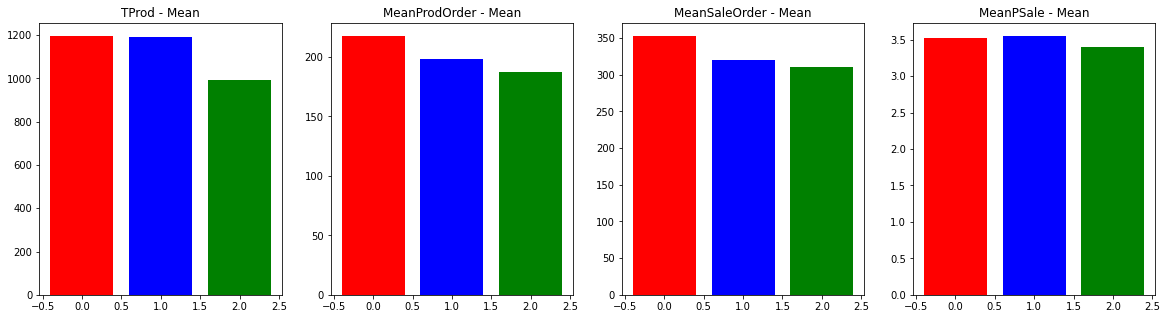

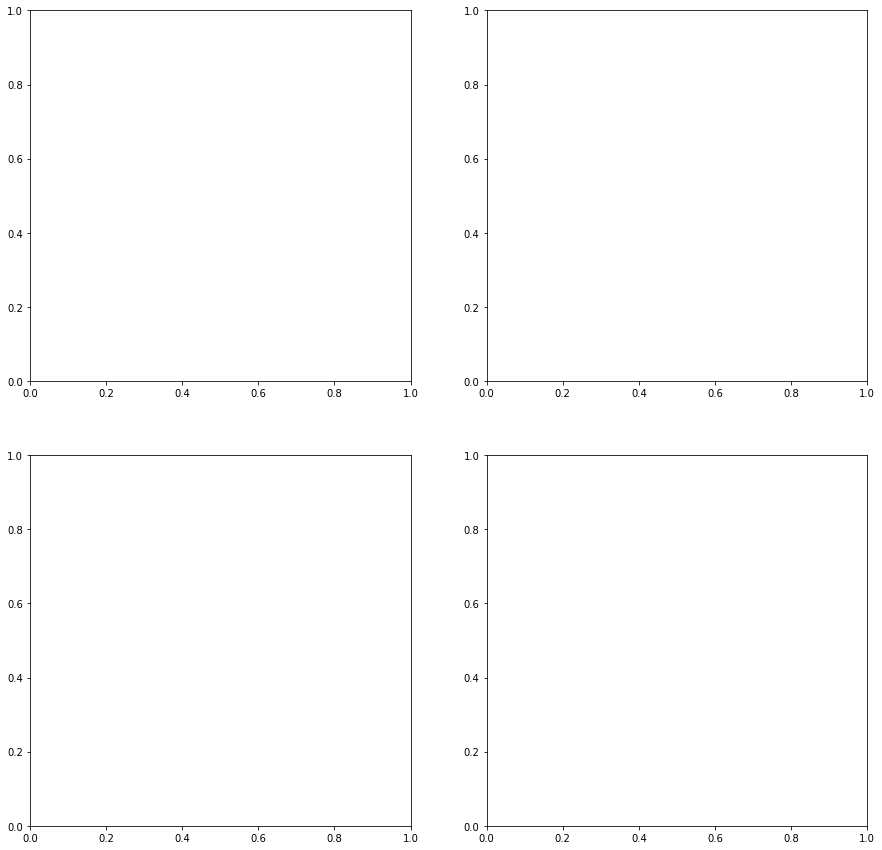

In [10]:
clust_ord = calc_silhouette(df_norm, cl)
plot_stats(mv, cl)
plot_dist(df_aux, clust_ord)

As we can see from the results it seems to not be able to find a good clustering.<br>
This may be related to the fact that this type of algorithm is strictly related to the values of its parameters and possibly needs a long time to converge to a good result.<br>
Furthermore, our data its not very evenly distributed so the intra-cluster variance is not robust and it effects the result of the algorithm. 

In [ ]:
# memory cleaning to avoid saturation
del nc, pc, cc, mg, mv, cl, clust_ord